# Analyse der Bearbeitungszeit von Chicago Service Requests

## 1. Datenvorbereitung und Bereinigung

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import scipy.stats as stats

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_info_columns', 10_000)   # zeigt alle Spaltennamen in info()
pd.set_option('display.max_info_rows', 200_000)     # zeigt Zeileninfo, wenn nötig

path = Path("dataset/311_Service_Requests_2024.csv")

df = pd.read_csv(path)

In [3]:
df['CREATED_DATE'] = pd.to_datetime(df['CREATED_DATE'], errors='coerce')
df['CLOSED_DATE'] = pd.to_datetime(df['CLOSED_DATE'], errors='coerce')

### Konstruktion der Zielvariable Bearbeitungszeit

In [4]:
# In Tagen
df["response_time"] = (df["CLOSED_DATE"] - df["CREATED_DATE"]).dt.total_seconds() / (60 * 60 * 24)

# In Stunden
df["response_time_hours"] = df["response_time"] * 24

In [71]:
zeit_neg = int((df["response_time"] < 0).sum())
print(f"Negative Bearbeitungszeiten: {zeit_neg}")

Negative Bearbeitungszeiten: 0


In [6]:
# Missing Values in den für die Bearbeitungszeit
df[['CREATED_DATE', 'CLOSED_DATE']].isna().sum()

CREATED_DATE        0
CLOSED_DATE     42387
dtype: int64

**Einordnung der fehlenden Bearbeitungszeiten**

Die fehlenden Werte der Bearbeitungszeit ergeben sich ausschliesslich aus offenen 
Service Requests. Offene Anfragen besitzen per Definition kein Abschlussdatum 
(CLOSED_DATE), sodass keine Bearbeitungszeit berechnet werden kann (siehe Kapitel 2). 

Die Missing Values stellen daher kein Datenqualitätsproblem dar, sondern sind 
strukturell durch den Status der Requests bedingt.

Die Zielvariable wird einmalig auf der Grundgesamtheit konstruiert und anschließend konsistent in allen Teilanalysen verwendet.

## 2. Deskriptive Analyse des Status

### Status der Requests (open / completed / canceled)

In [7]:
df["STATUS"] = df["STATUS"].str.lower()

erledigt = df[df["STATUS"] == "completed"].copy()
offen = df[df["STATUS"] == "open"].copy()
abgebrochen = df[df["STATUS"] == "canceled"].copy()

overview = pd.DataFrame({
    "Status": ["Erledigt", "Offen", "Abgebrochen"],
    "Anzahl": [len(erledigt), len(offen), len(abgebrochen)],
})

print("\nÜbersicht der Bearbeitungszeiten:")
print(overview)


Übersicht der Bearbeitungszeiten:
        Status   Anzahl
0     Erledigt  1832119
1        Offen    42387
2  Abgebrochen    39423


### Zeitliche Entwicklung der Statusanteile pro Monat

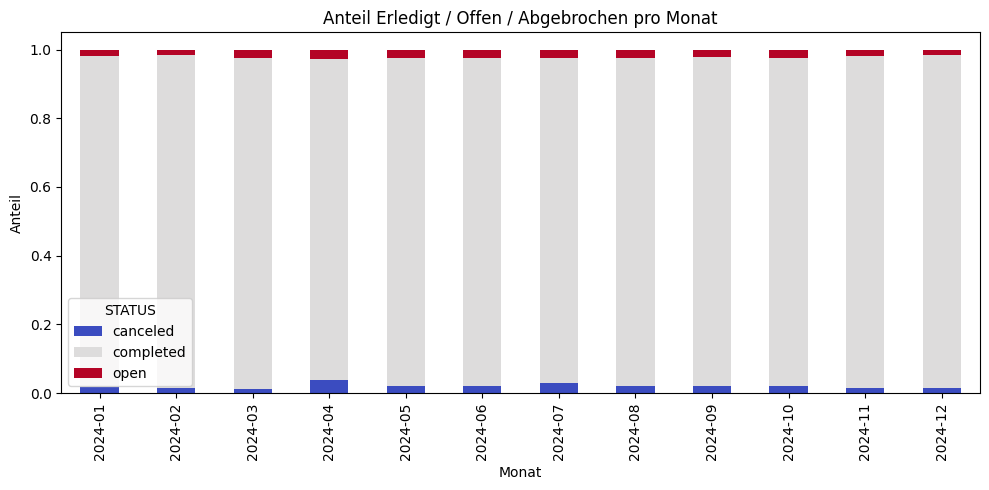

In [8]:
df["month"] = df["CREATED_DATE"].dt.to_period("M")
status_by_month = df.groupby(["month", "STATUS"]).size().unstack(fill_value=0)

(status_by_month.T / status_by_month.sum(axis=1)).T.plot(
    kind="bar", stacked=True, figsize=(10,5), colormap="coolwarm"
)
plt.title("Anteil Erledigt / Offen / Abgebrochen pro Monat")
plt.ylabel("Anteil")
plt.xlabel("Monat")
plt.tight_layout()
plt.show()

## 3. Analyse der Bearbeitungszeit (global)

In [9]:
min_days = round(df["response_time"].min(), 2)
max_days = round(df["response_time"].max(), 2)

min_hours = round(df["response_time_hours"].min(), 2)
max_hours = round(df["response_time_hours"].max(), 2)

print(f"Kürzeste Bearbeitungszeit: {min_days} Tage  ({min_hours} Stunden)")
print(f"Längste Bearbeitungszeit:  {max_days} Tage  ({max_hours} Stunden)")

Kürzeste Bearbeitungszeit: 0.0 Tage  (0.0 Stunden)
Längste Bearbeitungszeit:  638.82 Tage  (15331.56 Stunden)


### Bearbeitungszeit abgebrochener Service Requests

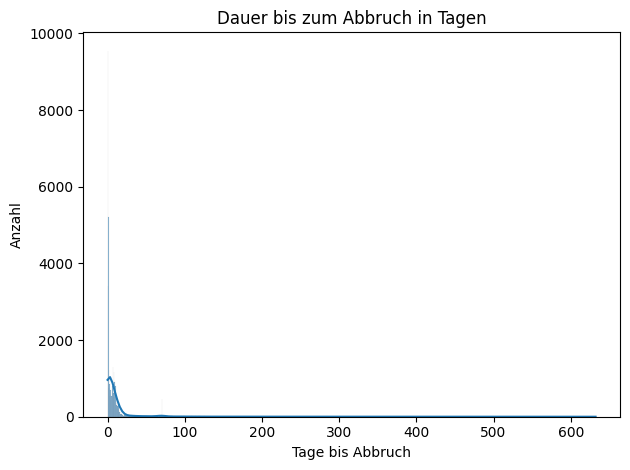

In [10]:
abgebrochen["cancel_time_days"] = ((abgebrochen["CLOSED_DATE"] - abgebrochen["CREATED_DATE"]).dt.total_seconds() / (60*60*24))

sns.histplot(abgebrochen["cancel_time_days"], bins="fd", kde=True)
plt.title("Dauer bis zum Abbruch in Tagen")
plt.xlabel("Tage bis Abbruch")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

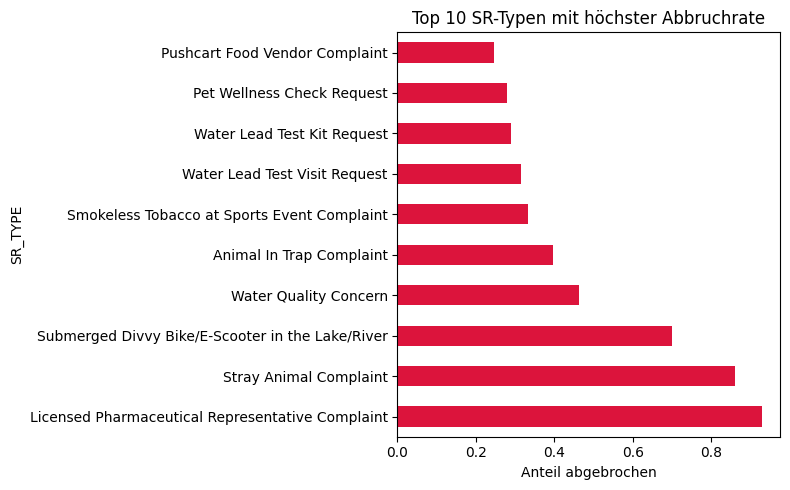

In [11]:
cancel_rate = (df.groupby("SR_TYPE")["STATUS"]
    .apply(lambda s: (s == "canceled").mean())
    .sort_values(ascending=False)
)

cancel_rate.head(10).plot(kind="barh", color="crimson", figsize=(8,5))
plt.title("Top 10 SR-Typen mit höchster Abbruchrate")
plt.xlabel("Anteil abgebrochen")
plt.tight_layout()
plt.show()

### Bearbeitungszeit offener Service Requests

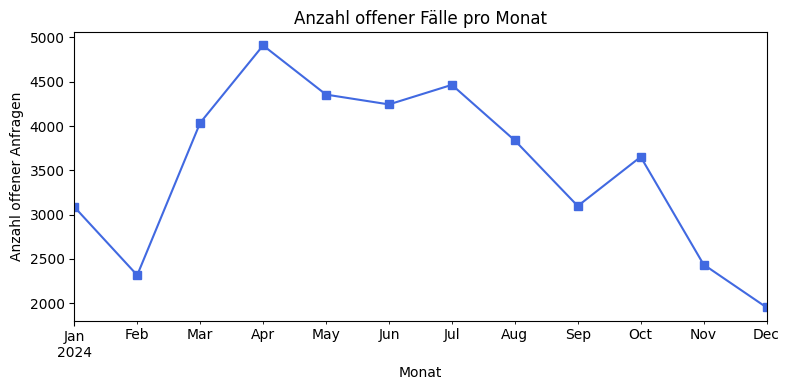

In [12]:
open_trend = df[df["STATUS"] == "open"].groupby(df["CREATED_DATE"].dt.to_period("M")).size()

open_trend.plot(marker="s", color="royalblue", figsize=(8,4))
plt.title("Anzahl offener Fälle pro Monat")
plt.xlabel("Monat")
plt.ylabel("Anzahl offener Anfragen")
plt.tight_layout()
plt.show()

Die Anzahl offener Anfragen schwankt stark über das Jahr.
Es gibt ein deutliches Maximum im Frühling (April rund 5000 offene Fälle).
Danach sinkt der Wert kontinuierlich gegen Jahresende nur noch rund 2000 Fälle.

In [13]:
# Hängen hohe Fallzahlen mit hoher Aktiviät oder Rückständen zusammen
closed_trend = df[df["STATUS"] == "completed"].groupby(df["CREATED_DATE"].dt.to_period("M")).size()

corr_value = open_trend.corr(closed_trend)
print(f"Korrelation zwischen offenen und erledigten Fällen: {corr_value:.2f}")

Korrelation zwischen offenen und erledigten Fällen: 0.85


Positive Korrelation, was bedeutet in Monaten mit vielen offenen Fällen gibt es auch viele abgeschlossene. 
Dies deutet daraufhin, dass es viel Aufträge zwar gibt, diese dennoch effizient abgearbeitet werden.

### Bearbeitungszeit abgeschlossener Service Requests

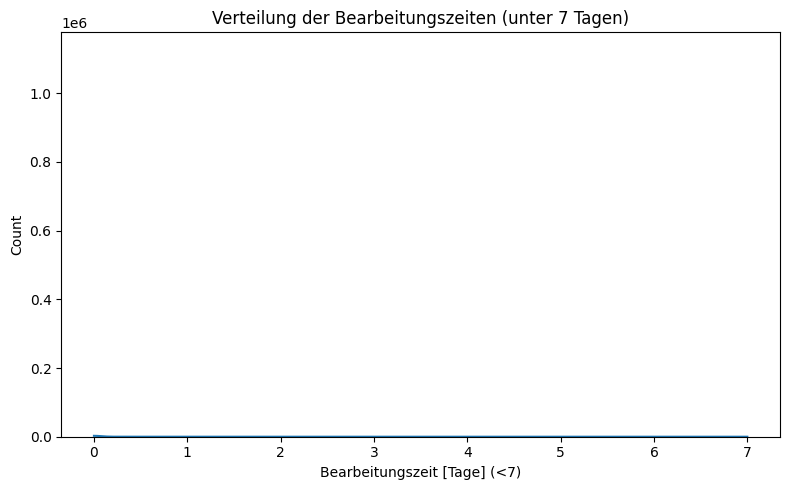

In [14]:
subset = erledigt[erledigt["response_time"] < 7]  # unter 7 Tage

plt.figure(figsize=(8,5))
sns.histplot(subset["response_time"], bins="fd", kde=True)
plt.xlabel("Bearbeitungszeit [Tage] (<7)")
plt.title("Verteilung der Bearbeitungszeiten (unter 7 Tagen)")
plt.tight_layout()
plt.show()

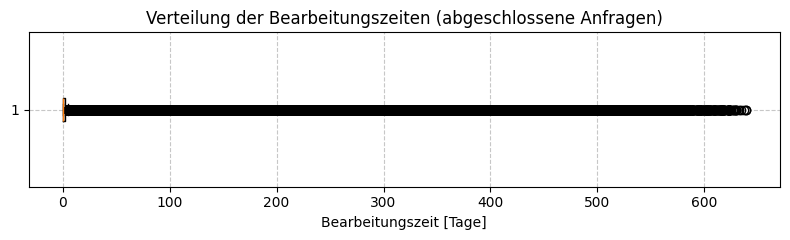

In [15]:
plt.figure(figsize=(8,2.5))
plt.boxplot(erledigt["response_time"].dropna(), vert=False)
plt.title("Verteilung der Bearbeitungszeiten (abgeschlossene Anfragen)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

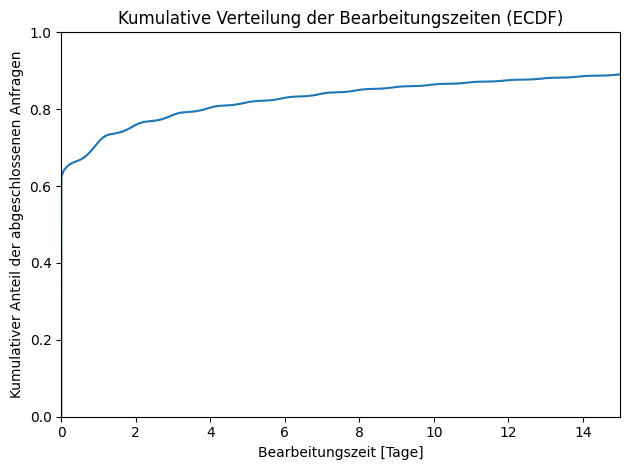

In [16]:
sns.ecdfplot(data=erledigt, x="response_time")
plt.xlim(0, 15)
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Kumulativer Anteil der abgeschlossenen Anfragen")
plt.title("Kumulative Verteilung der Bearbeitungszeiten (ECDF)")
plt.tight_layout()
plt.show()

#### Robuste Verteilungsdiagnostik

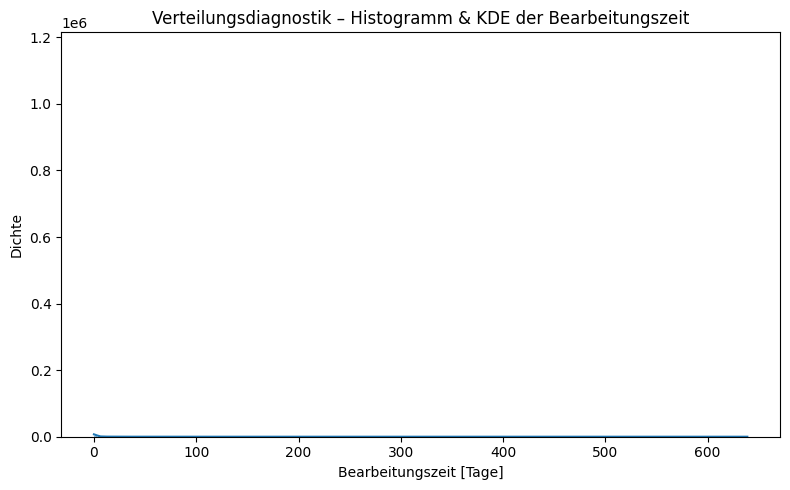

In [17]:
# Histogramm + KDE (zur visuellen Form)
plt.figure(figsize=(8,5))
sns.histplot(erledigt["response_time"], bins="fd", kde=True)
plt.title("Verteilungsdiagnostik – Histogramm & KDE der Bearbeitungszeit")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Dichte")
plt.tight_layout()
plt.show()

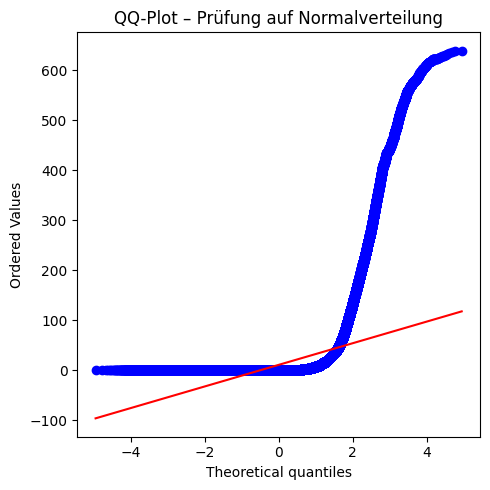

In [18]:
# QQ-Plot zur Normalitätsprüfung
plt.figure(figsize=(5,5))
stats.probplot(erledigt["response_time"].dropna(), dist="norm", plot=plt)
plt.title("QQ-Plot – Prüfung auf Normalverteilung")
plt.tight_layout()
plt.show()

Interpretation
Die blaue Kurve verläuft stark nach oben rechts und unten flach. Das bedeutet, die Verteilung der response_time weicht stark von der Normalverteilung ab.

Ausserdem liegen die Punkte im mittleren Bereich kurz auf der roten Linie, danach steigen sie abrupt an. Die Verteilung ist dementsprechend stark rechtsschief, das heisst also, es gibt viele kleine Werte (kurze Bearbeitungszeiten) und einige sehr grosse Ausreisser mit extrem langen Bearbeitungszeiten.

In [19]:
# Schiefe
skewness = erledigt["response_time"].skew()
print(f"Schiefe (Skewness): {skewness:.2f}")

# Interpretation
if skewness > 1:
    print("Stark rechtsschief: Median ist robuster als Mittelwert.")
elif skewness > 0.5:
    print("Mässig rechtsschief: leichte Verzerrung, Median bevorzugen.")
elif skewness < -0.5:
    print("Linksschief: Daten eher links verzerrt.")
else:
    print("Symmetrische Verteilung: Mittelwert repräsentativ.")

Schiefe (Skewness): 6.83
Stark rechtsschief: Median ist robuster als Mittelwert.


### Bearbeitungszeit nach Service Type

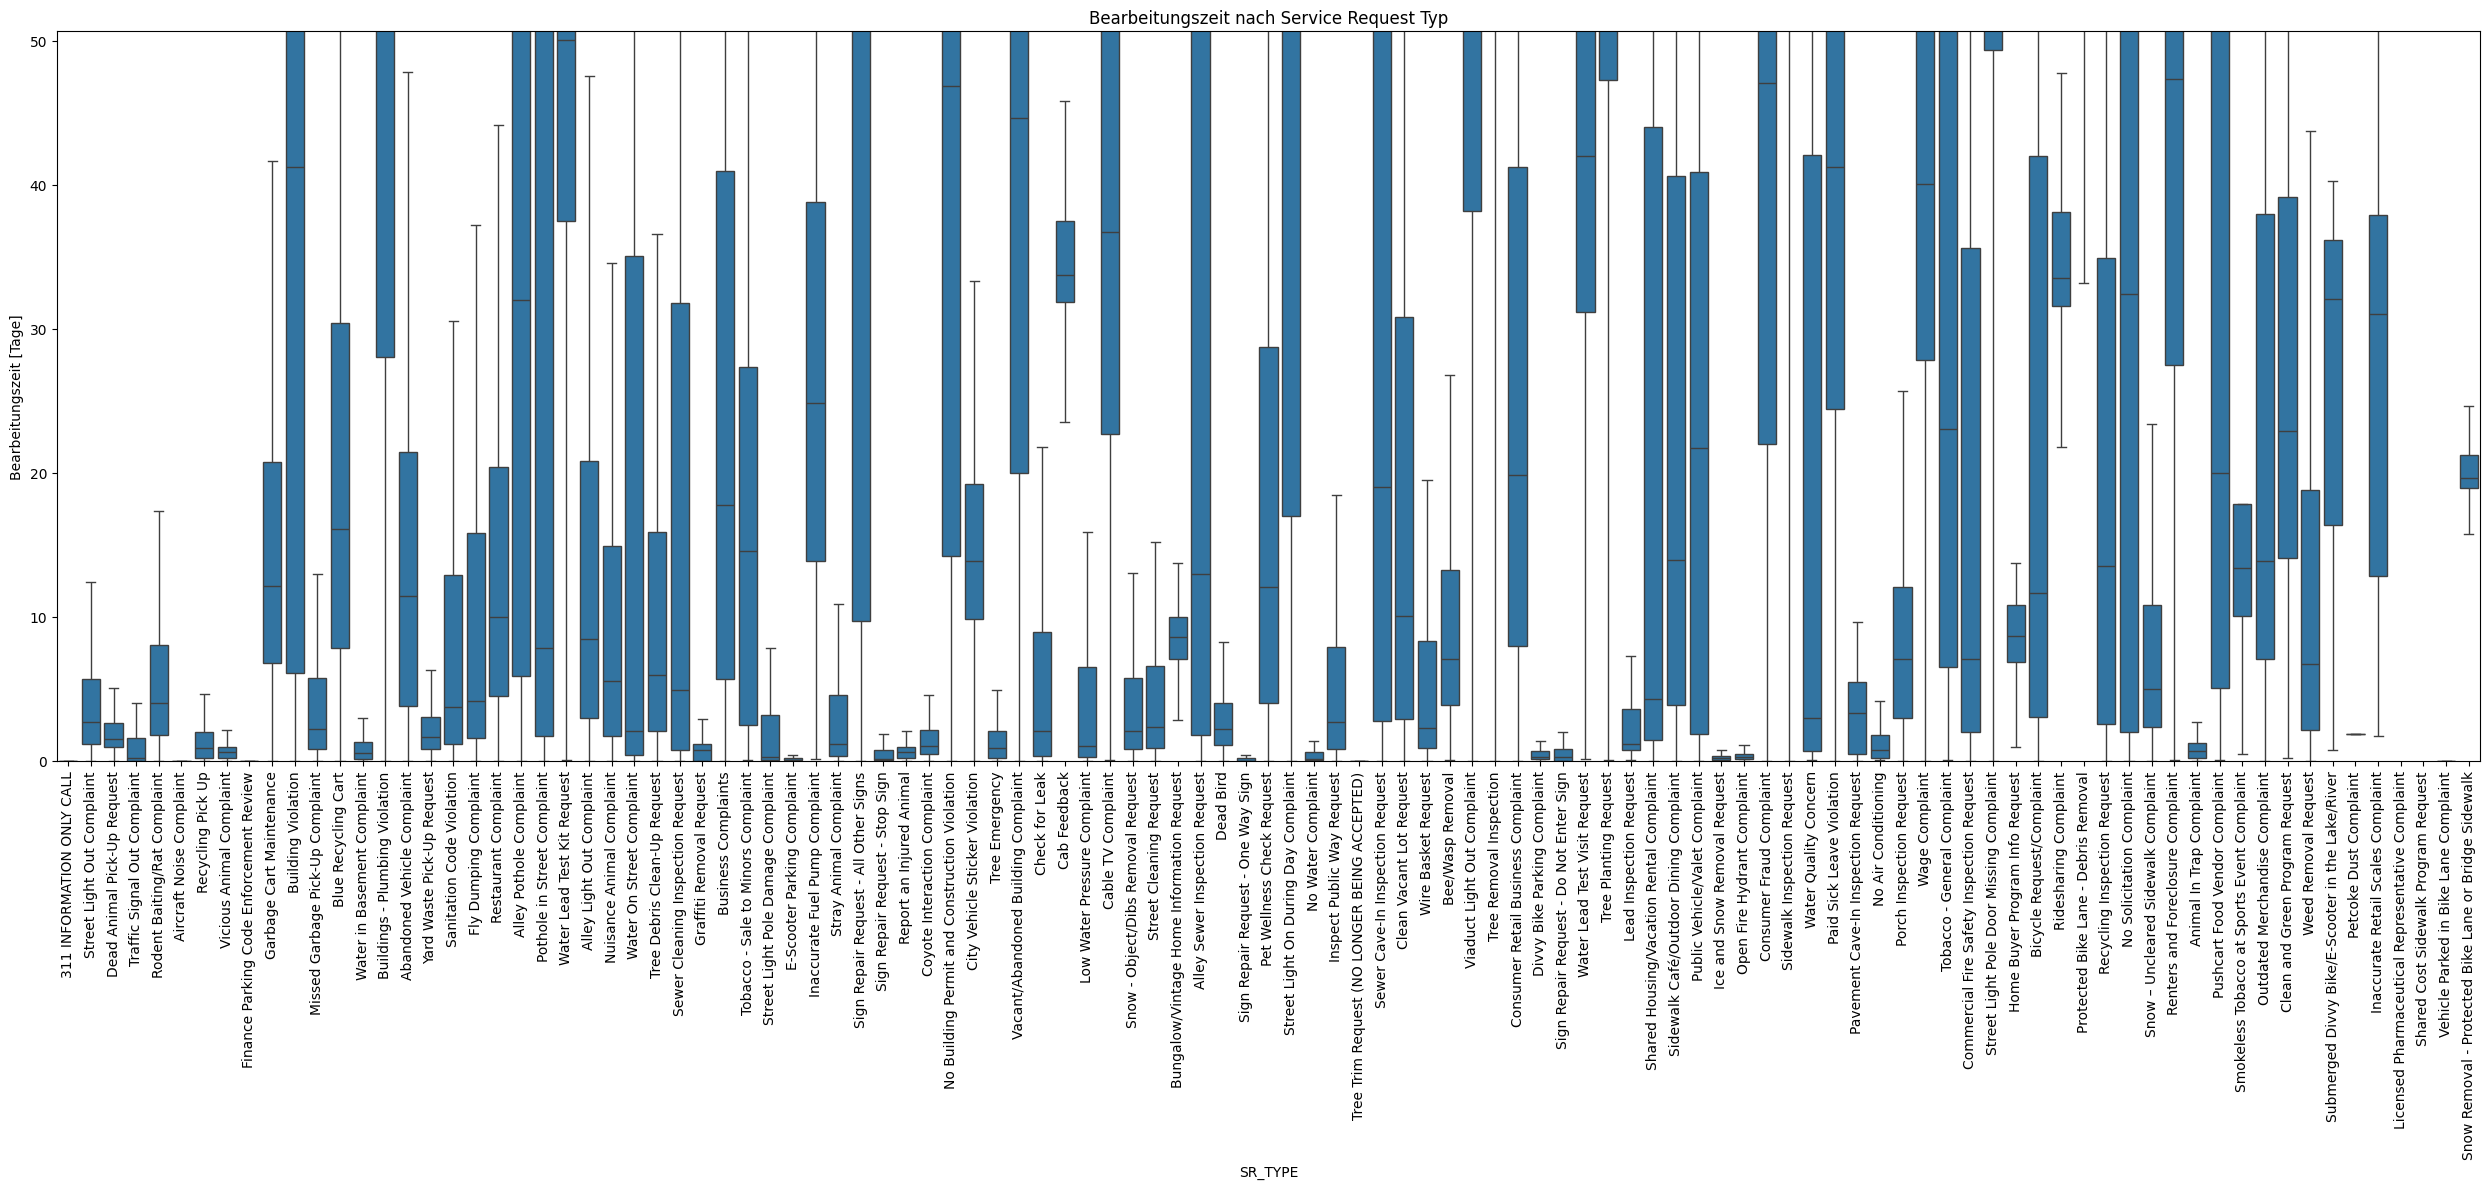

In [20]:
plt.figure(figsize=(25,12))
sns.boxplot(x="SR_TYPE", y="response_time", data=erledigt, showfliers=False)
plt.xticks(rotation=90)
plt.ylabel("Bearbeitungszeit [Tage]")
plt.title("Bearbeitungszeit nach Service Request Typ")
plt.ylim(0, erledigt["response_time"].quantile(0.95)) # um extreme Ausreisser erstmals nicht berücksichtigen 
plt.tight_layout()
plt.show()

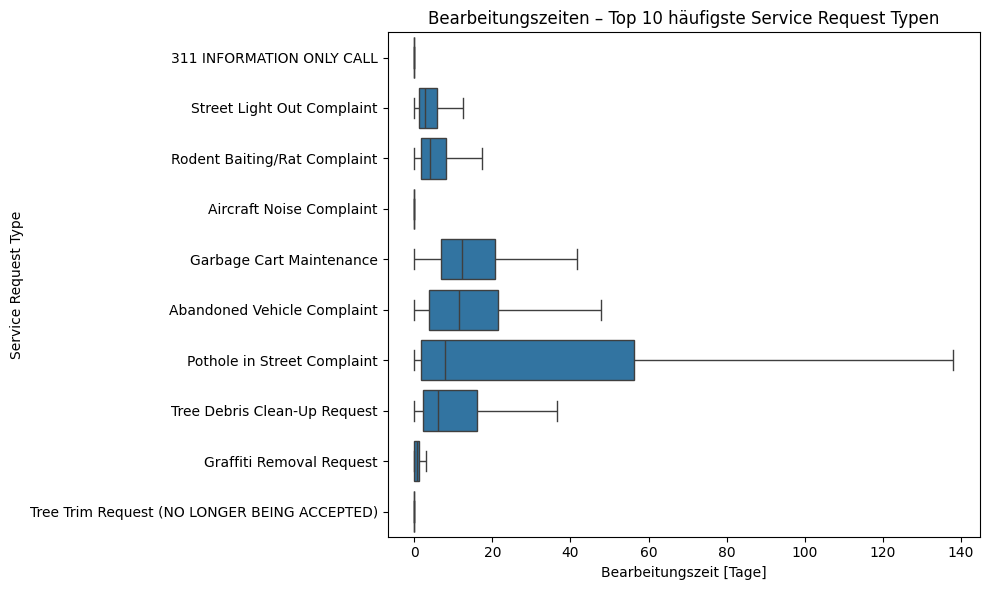

In [21]:
# Top 10 häufigste SR-Typen
top_types = erledigt["SR_TYPE"].value_counts().head(10).index
subset_top = erledigt[erledigt["SR_TYPE"].isin(top_types)]

plt.figure(figsize=(10,6))
sns.boxplot(data=subset_top, y="SR_TYPE", x="response_time", showfliers=False)
plt.title("Bearbeitungszeiten – Top 10 häufigste Service Request Typen")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

Durchschnittliche Bearbeitungszeit pro SR_TYPE

In [22]:
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

avg_time_by_type = (
    erledigt.groupby("SR_TYPE")
    .agg(
        mean_days=("response_time", "mean"),       # klassischer Mittelwert
        median_days=("response_time", "median"),   # Median
        iqr_days=("response_time", iqr),           # IQR
        mean_hours=("response_time_hours", "mean"),
        median_hours=("response_time_hours", "median")
    )
    .round(2)
    .sort_values(by="median_days", ascending=False)
    .reset_index()
)

# Top 10 und Bottom 10 nach Median
top10 = avg_time_by_type.head(10)
bottom10 = avg_time_by_type.tail(10)

print("\nTop 10 mit längster Bearbeitungszeit (nach Median):\n")
print(top10[["SR_TYPE", "median_days", "iqr_days"]].to_string(index=False))

print("\nBottom 10 mit kürzester Bearbeitungszeit (nach Median):\n")
print(bottom10[["SR_TYPE", "median_days", "iqr_days"]].to_string(index=False))



Top 10 mit längster Bearbeitungszeit (nach Median):

                                 SR_TYPE  median_days  iqr_days
    Shared Cost Sidewalk Program Request       435.90     24.91
    Protected Bike Lane - Debris Removal       343.44    175.05
             Sidewalk Inspection Request       281.13    186.40
                 Tree Removal Inspection       162.10    139.75
                   Tree Planting Request       149.98    262.74
Street Light Pole Door Missing Complaint       147.61    314.62
   Sign Repair Request - All Other Signs       104.67    260.06
             Viaduct Light Out Complaint        99.29    173.19
          Buildings - Plumbing Violation        83.94    137.79
    Street Light On During Day Complaint        72.88    169.09

Bottom 10 mit kürzester Bearbeitungszeit (nach Median):

                                     SR_TYPE  median_days  iqr_days
                Ice and Snow Removal Request         0.16      0.28
                          No Water Complaint    

Interpretation
Bearbeitungszeit stark abhängig vom Request-Typ.
Die meisten Service Requests werden extrem schnell erledigt (Median ca. 0 Tage).
Nur einige wenige Typen insbesondere Bau-, Inspektions- und Baumprojekte ziehen den Gesamtdurchschnitt nach oben und zeigen grosse Streuung.

#### Visuelle Analyse zum Zusammenhang zwischen Request-Typ und Bearbeitungszeit

Balkendiagramme (Top/Bottom 10 nach Median)

C:\Users\erica\AppData\Local\Temp\ipykernel_3928\2534669083.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


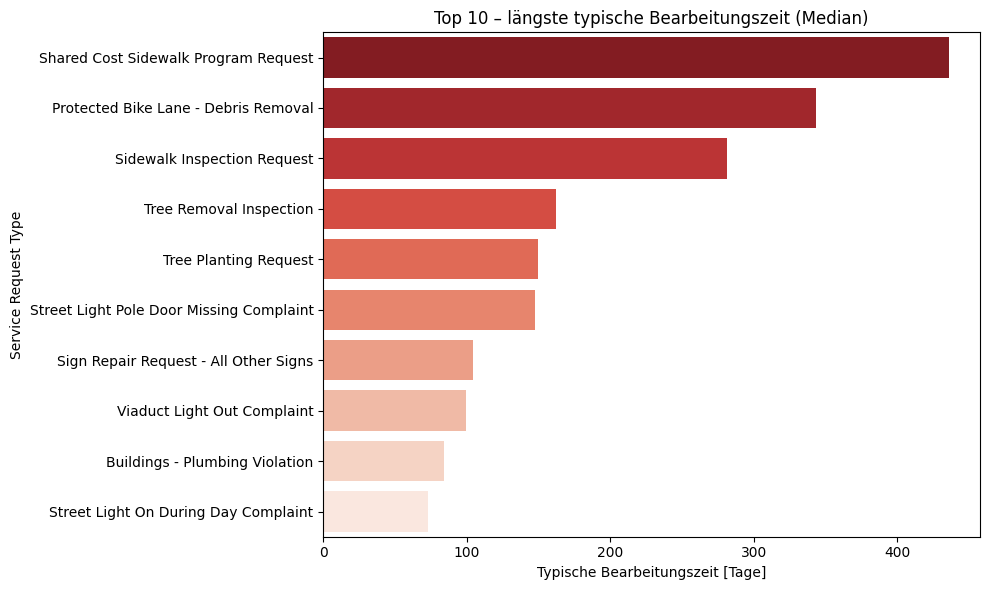

In [23]:
# Top 10
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10.sort_values(by="median_days", ascending=False),
    x="median_days",
    y="SR_TYPE",
    palette="Reds_r",
    errorbar=None  # keine Konfidenzintervalle des Mittelwerts anzeigen
)
plt.title("Top 10 – längste typische Bearbeitungszeit (Median)")
plt.xlabel("Typische Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()


Interpretation
Das sind komplexe Projekte mit mehrstufigen und administrativen Abläufen, welche entsprechend mehr Zeit beantspruchen zur Finanzierung, Planung und Bauverwaltung. Diese Service-Typen betreffen langfristige oder genehmigungspflichtige Arbeiten (Bau, Infrastruktur, Umwelt).

Der hohe Median deutet klar auf Prozesse mit Wartezeiten, Planung oder Abhängigkeiten hin.
Dies weist auf mehrstufige Abläufe, Abhängigkeiten von Jahreszeiten oder externen Auftragnehmern.

In Kombination mit den hohen IQR-Werten (aus deiner Tabelle zuvor) zeigt sich, dass diese Prozesse nicht nur lang, sondern auch ungleichmässig ablaufen, also dass grosse Unterschiede zwischen einzelnen Fällen bestehen.

C:\Users\erica\AppData\Local\Temp\ipykernel_3928\3890670959.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


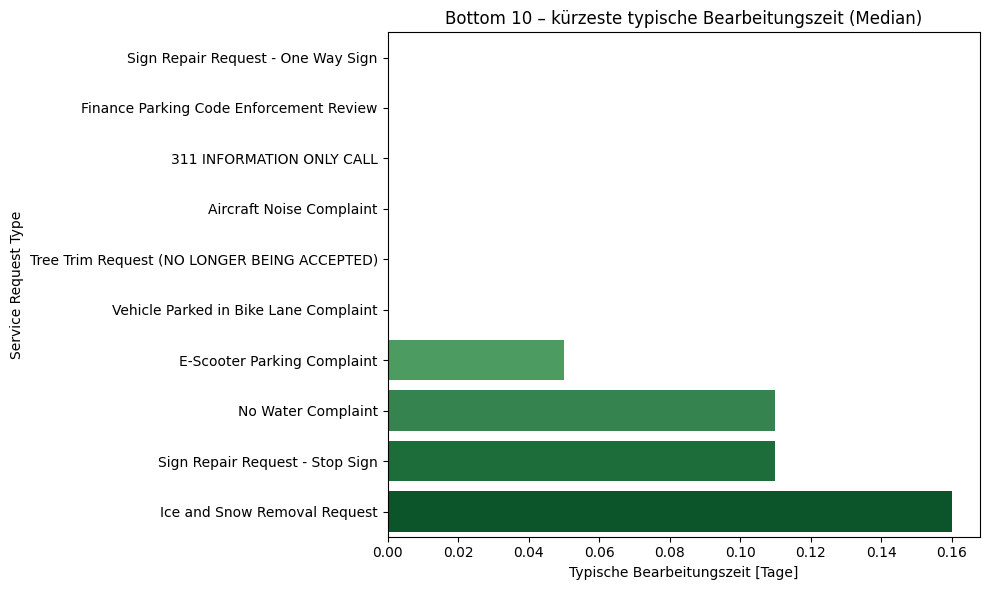

In [24]:
# Bottom 10
plt.figure(figsize=(10,6))
sns.barplot(
    data=bottom10.sort_values(by="median_days", ascending=True),
    x="median_days",
    y="SR_TYPE",
    palette="Greens",
    errorbar=None
)
plt.title("Bottom 10 – kürzeste typische Bearbeitungszeit (Median)")
plt.xlabel("Typische Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

Interpretation
Die kürzesten Bearbeitungszeiten finden sich bei standardisierten Routine- und Sicherheitsmeldungen, die sofort bearbeitet oder automatisch abgeschlossen werden.
Diese Prozesse sind effizient, konsistent und zeigen kaum Schwankungen, was ein guter Indikator für automatisierte Abläufe ist.

Boxplots Verteilung der Top/Bottom 10 nach Median

C:\Users\erica\AppData\Local\Temp\ipykernel_3928\2012741625.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


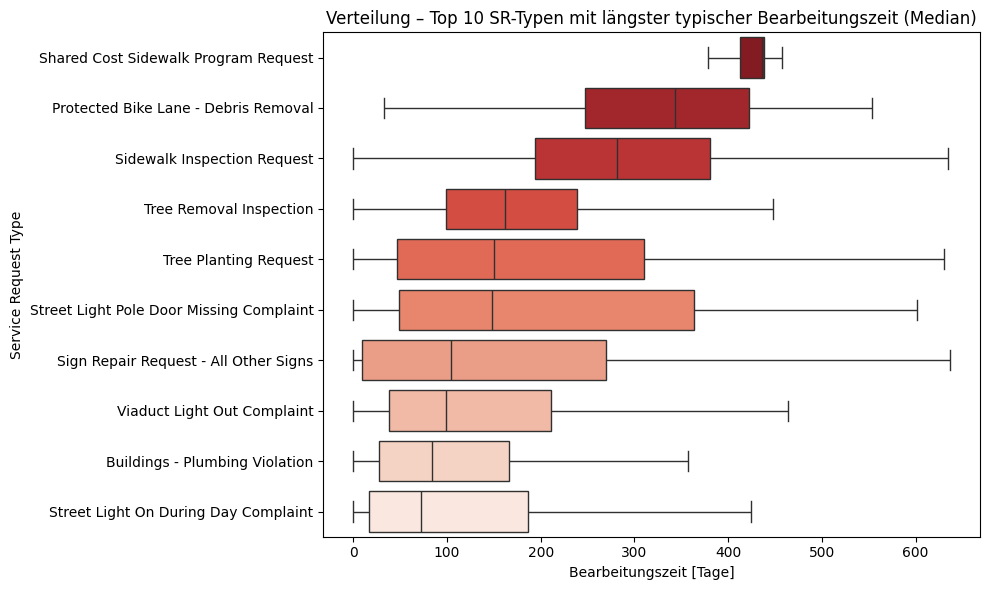

C:\Users\erica\AppData\Local\Temp\ipykernel_3928\2012741625.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


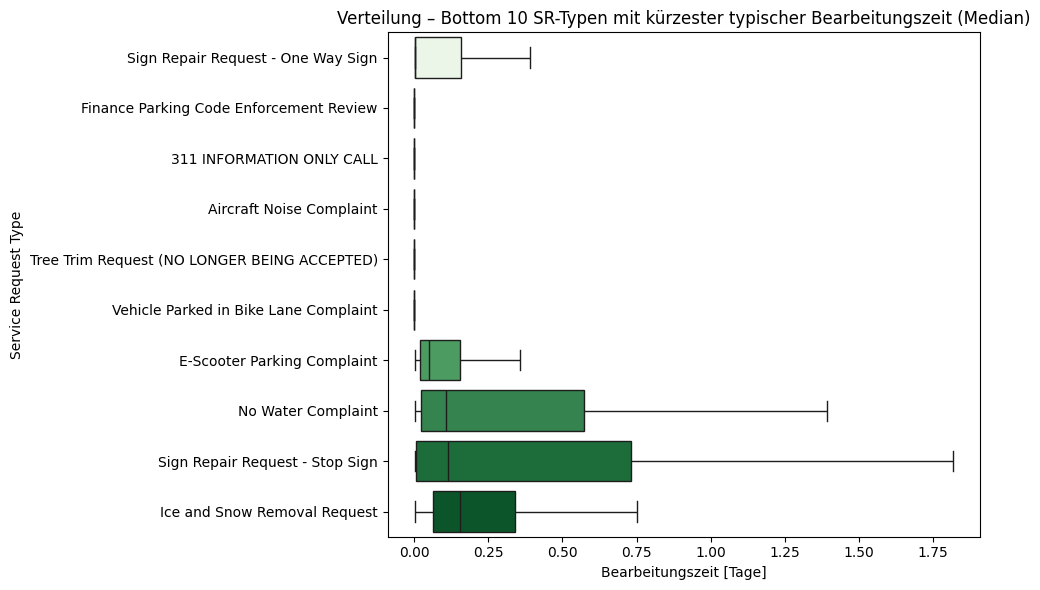

In [25]:
# Top 10 
top_types_sorted = top10.sort_values(by="median_days", ascending=False)["SR_TYPE"]
subset_top10 = erledigt[erledigt["SR_TYPE"].isin(top_types_sorted)]

plt.figure(figsize=(10,6))
sns.boxplot(
    data=subset_top10,
    y="SR_TYPE",
    x="response_time",
    order=top_types_sorted,     # Sortierung nach Median
    showfliers=False,
    palette="Reds_r"
)
plt.title("Verteilung – Top 10 SR-Typen mit längster typischer Bearbeitungszeit (Median)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

# Bottom 10
bottom_types_sorted = bottom10.sort_values(by="median_days", ascending=True)["SR_TYPE"]
subset_bottom10 = erledigt[erledigt["SR_TYPE"].isin(bottom_types_sorted)]

plt.figure(figsize=(10,6))
sns.boxplot(
    data=subset_bottom10,
    y="SR_TYPE",
    x="response_time",
    order=bottom_types_sorted,  # Sortierung nach Median
    showfliers=False,
    palette="Greens"
)
plt.title("Verteilung – Bottom 10 SR-Typen mit kürzester typischer Bearbeitungszeit (Median)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()


C:\Users\erica\AppData\Local\Temp\ipykernel_3928\2991806316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\erica\AppData\Local\Temp\ipykernel_3928\2991806316.py:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


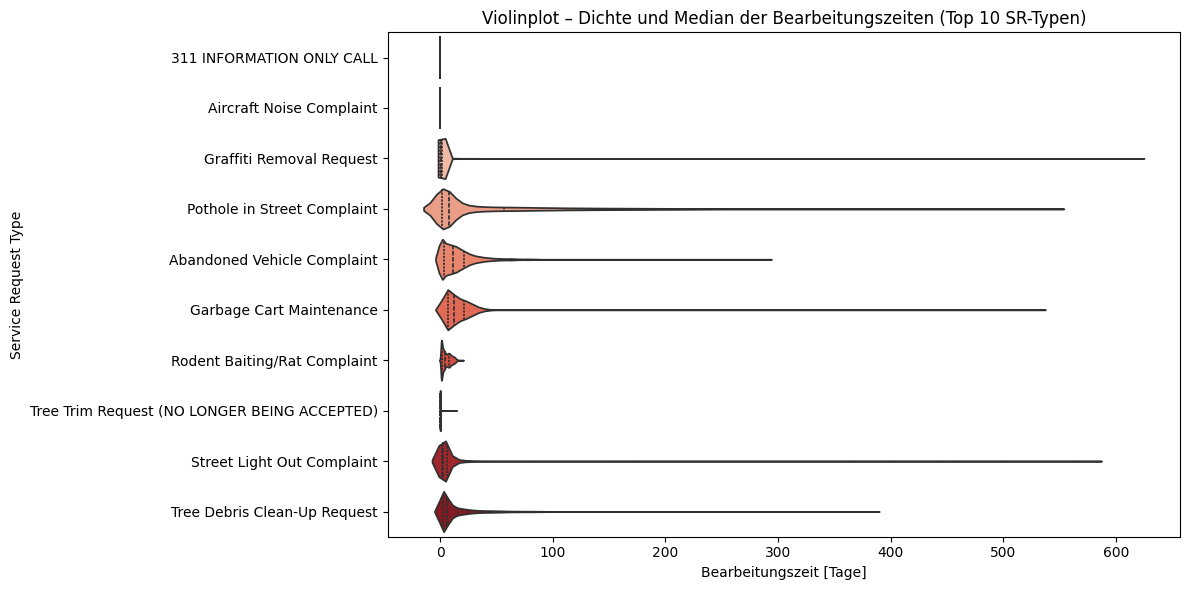

In [26]:
# Violinplot
plt.figure(figsize=(12,6))
sns.violinplot(
    data=erledigt[erledigt["SR_TYPE"].isin(top_types)],
    y="SR_TYPE",
    x="response_time",
    order=top_types,
    scale="width",
    inner="quartile",
    palette="Reds"
)
plt.title("Violinplot – Dichte und Median der Bearbeitungszeiten (Top 10 SR-Typen)")
plt.xlabel("Bearbeitungszeit [Tage]")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()


#### Wahrscheinlichkeit und Verteilungen

In [27]:
# Gesamte Wahrscheinlichkeit über alle Anfragen, dass die Bearbeitungszeit folgende Wahrscheinlichkeiten berträgt:

p_over_1 = (erledigt["response_time"] > 1).mean() # mean() um die True Werte zu bekommen
p_under_1 = (erledigt["response_time"] < 1).mean()
p_over_10 = (erledigt["response_time"] > 10).mean()
p_over_30 = (erledigt["response_time"] > 30).mean()

print(f"P(X > 1 Tag)   = {p_over_1:.2%}")
print(f"P(X < 1 Tag)   = {p_under_1:.2%}")
print(f"P(X > 10 Tage) = {p_over_10:.2%}")
print(f"P(X > 30 Tage) = {p_over_30:.2%}")


P(X > 1 Tag)   = 28.50%
P(X < 1 Tag)   = 71.50%
P(X > 10 Tage) = 13.56%
P(X > 30 Tage) = 7.21%


Wahrscheinlichkeit P(X > 10 Tage) je Service Request Type zur Bearbeitung

In [28]:
# Wahrscheinlichkeit je SR_TYPE
prob_over10_by_type = (
    erledigt.groupby("SR_TYPE")["response_time"]
    .apply(lambda x: (x > 10).mean())
    .sort_values(ascending=False)
)

# Tabellenansicht
print("\nTop 10 SR-Typen mit höchster Wahrscheinlichkeit > 10 Tage:\n")
print(prob_over10_by_type.head(10).round(3))

print("\nBottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit > 10 Tage:\n")
print(prob_over10_by_type.tail(10).round(3))


Top 10 SR-Typen mit höchster Wahrscheinlichkeit > 10 Tage:

SR_TYPE
Licensed Pharmaceutical Representative Complaint         1.000
Shared Cost Sidewalk Program Request                     1.000
Protected Bike Lane - Debris Removal                     1.000
Snow Removal - Protected Bike Lane or Bridge Sidewalk    1.000
Water Lead Test Kit Request                              0.994
Sidewalk Inspection Request                              0.993
Tree Removal Inspection                                  0.984
Water Lead Test Visit Request                            0.978
Cab Feedback                                             0.972
Tree Planting Request                                    0.962
Name: response_time, dtype: float64

Bottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit > 10 Tage:

SR_TYPE
Vicious Animal Complaint                        0.0
Finance Parking Code Enforcement Review         0.0
Dead Animal Pick-Up Request                     0.0
Tree Trim Request (NO LONGER BEING

C:\Users\erica\AppData\Local\Temp\ipykernel_3928\67737570.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


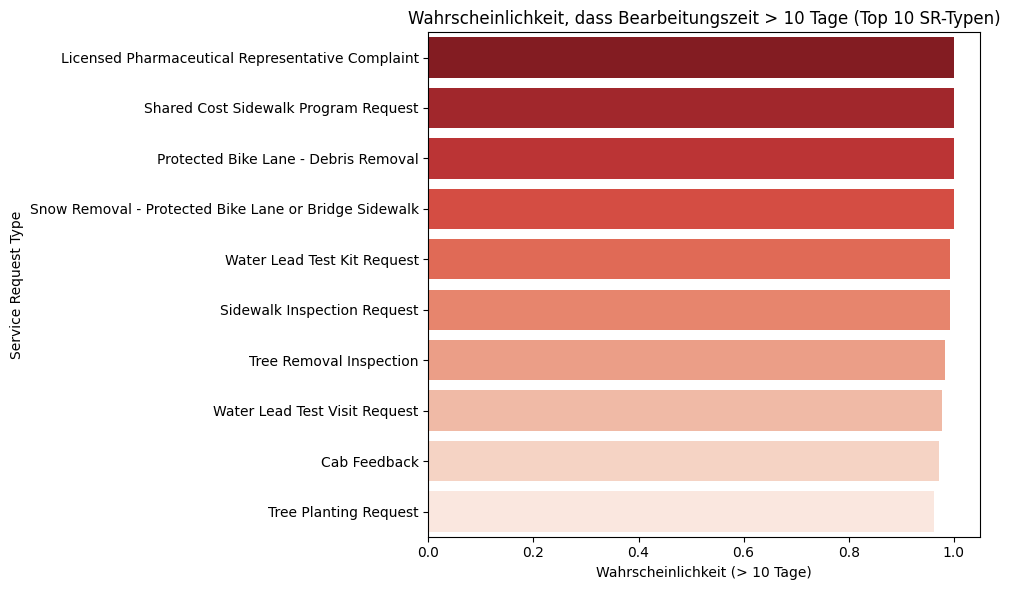

In [29]:
# Visualisierung: Top 10
top10_prob = prob_over10_by_type.head(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_prob,
    x="response_time",
    y="SR_TYPE",
    palette="Reds_r"
)
plt.title("Wahrscheinlichkeit, dass Bearbeitungszeit > 10 Tage (Top 10 SR-Typen)")
plt.xlabel("Wahrscheinlichkeit (> 10 Tage)")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

Wahrscheinlichkeit P(X < 1 Tag) je Service Request Type zur Bearbeitung

In [30]:
# Wahrscheinlichkeit je SR_TYPE
prob_under1_by_type = (
    erledigt.groupby("SR_TYPE")["response_time"]
    .apply(lambda x: (x < 1).mean())
    .sort_values(ascending=False)
)

# Tabellenansicht
print("\nTop 10 SR-Typen mit höchster Wahrscheinlichkeit < 1 Tag:\n")
print(prob_under1_by_type.head(10).round(3))

print("\nBottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit <1 Tag:\n")
print(prob_under1_by_type.tail(10).round(3))


Top 10 SR-Typen mit höchster Wahrscheinlichkeit < 1 Tag:

SR_TYPE
311 INFORMATION ONLY CALL                       1.000
Aircraft Noise Complaint                        1.000
Vehicle Parked in Bike Lane Complaint           1.000
Tree Trim Request (NO LONGER BEING ACCEPTED)    1.000
Finance Parking Code Enforcement Review         1.000
Ice and Snow Removal Request                    0.987
Sign Repair Request - Stop Sign                 0.958
Sign Repair Request - One Way Sign              0.932
E-Scooter Parking Complaint                     0.877
Open Fire Hydrant Complaint                     0.871
Name: response_time, dtype: float64

Bottom 10 SR-Typen mit niedrigster Wahrscheinlichkeit <1 Tag:

SR_TYPE
Ridesharing Complaint                                    0.004
Tree Planting Request                                    0.003
Sidewalk Inspection Request                              0.002
Water Lead Test Kit Request                              0.001
Inaccurate Retail Scales Complain

C:\Users\erica\AppData\Local\Temp\ipykernel_3928\861929838.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


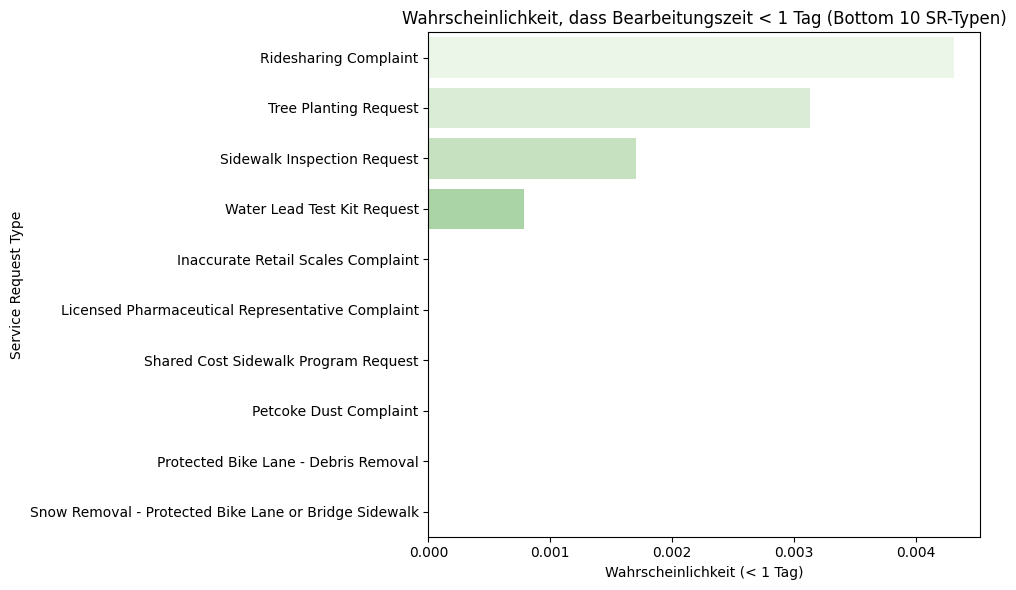

In [31]:
# Visualisierung: Bottom 10
bottom10_prob = prob_under1_by_type.tail(10).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=bottom10_prob,
    x="response_time",
    y="SR_TYPE",
    palette="Greens"
)
plt.title("Wahrscheinlichkeit, dass Bearbeitungszeit < 1 Tag (Bottom 10 SR-Typen)")
plt.xlabel("Wahrscheinlichkeit (< 1 Tag)")
plt.ylabel("Service Request Type")
plt.tight_layout()
plt.show()

#### Schätzung und Konfidenzintervalle

In [32]:
# 95%-Konfidenzintervall für den Mittelwert der Bearbeitungszeit
x = erledigt["response_time"].dropna()

mean = np.mean(x)
se = stats.sem(x)  # Standardfehler des Mittelwerts
ci = stats.t.interval(confidence=0.95, df=len(x)-1, loc=mean, scale=se)

print("95%-Konfidenzintervall für den Mittelwert der Bearbeitungszeit:")
print(f"Schätzer (Mittelwert): {mean:.2f} Tage")
print(f"95%-Konfidenzintervall: [{ci[0]:.2f}, {ci[1]:.2f}] Tage")

95%-Konfidenzintervall für den Mittelwert der Bearbeitungszeit:
Schätzer (Mittelwert): 10.52 Tage
95%-Konfidenzintervall: [10.46, 10.58] Tage


Interpretation
Der Mittelwert ist stark durch Ausreisser beeinflusst.
Es zeigt mit 95 % Sicherheit befindet sich der wahre Mittelwert der Bearbeitungszeit in diesem Intervall von [10.46, 10.58] Tagen.

Welche SR_TYPES die Bearbeitungszeit am stärksten beeinflussen

In [33]:
# Kruskal-Wallis-Test: Unterscheiden sich die Bearbeitungszeiten je nach SR_TYPE?
groups = [
    erledigt[erledigt["SR_TYPE"] == t]["response_time"]
    for t in erledigt["SR_TYPE"].unique()
]

stat, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {stat:.3f}, p = {p:.3f}")

Kruskal–Wallis H = 1527108.735, p = 0.000


In [34]:
import scikit_posthocs as sp

posthoc = sp.posthoc_dunn(
    erledigt,
    val_col="response_time",
    group_col="SR_TYPE",
    p_adjust="fdr_bh"
)
posthoc

,311 INFORMATION ONLY CALL,Abandoned Vehicle Complaint,Aircraft Noise Complaint,Alley Light Out Complaint,Alley Pothole Complaint,Alley Sewer Inspection Request,Animal In Trap Complaint,Bee/Wasp Removal,Bicycle Request/Complaint,Blue Recycling Cart,Building Violation,Buildings - Plumbing Violation,Bungalow/Vintage Home Information Request,Business Complaints,Cab Feedback,Cable TV Complaint,Check for Leak,City Vehicle Sticker Violation,Clean Vacant Lot Request,Clean and Green Program Request,Commercial Fire Safety Inspection Request,Consumer Fraud Complaint,Consumer Retail Business Complaint,Coyote Interaction Complaint,Dead Animal Pick-Up Request,Dead Bird,Divvy Bike Parking Complaint,E-Scooter Parking Complaint,Finance Parking Code Enforcement Review,Fly Dumping Complaint,Garbage Cart Maintenance,Graffiti Removal Request,Home Buyer Program Info Request,Ice and Snow Removal Request,Inaccurate Fuel Pump Complaint,Inaccurate Retail Scales Complaint,Inspect Public Way Request,Lead Inspection Request,Licensed Pharmaceutical Representative Complaint,Low Water Pressure Complaint,Missed Garbage Pick-Up Complaint,No Air Conditioning,No Building Permit and Construction Violation,No Solicitation Complaint,No Water Complaint,Nuisance Animal Complaint,Open Fire Hydrant Complaint,Outdated Merchandise Complaint,Paid Sick Leave Violation,Pavement Cave-In Inspection Request,Pet Wellness Check Request,Petcoke Dust Complaint,Porch Inspection Request,Pothole in Street Complaint,Protected Bike Lane - Debris Removal,Public Vehicle/Valet Complaint,Pushcart Food Vendor Complaint,Recycling Inspection Request,Recycling Pick Up,Renters and Foreclosure Complaint,Report an Injured Animal,Restaurant Complaint,Ridesharing Complaint,Rodent Baiting/Rat Complaint,Sanitation Code Violation,Sewer Cave-In Inspection Request,Sewer Cleaning Inspection Request,Shared Cost Sidewalk Program Request,Shared Housing/Vacation Rental Complaint,Sidewalk Café/Outdoor Dining Complaint,Sidewalk Inspection Request,Sign Repair Request - All Other Signs,Sign Repair Request - Do Not Enter Sign,Sign Repair Request - One Way Sign,Sign Repair Request - Stop Sign,Smokeless Tobacco at Sports Event Complaint,Snow - Object/Dibs Removal Request,Snow Removal - Protected Bike Lane or Bridge Sidewalk,Snow – Uncleared Sidewalk Complaint,Stray Animal Complaint,Street Cleaning Request,Street Light On During Day Complaint,Street Light Out Complaint,Street Light Pole Damage Complaint,Street Light Pole Door Missing Complaint,Submerged Divvy Bike/E-Scooter in the Lake/River,Tobacco - General Complaint,Tobacco - Sale to Minors Complaint,Traffic Signal Out Complaint,Tree Debris Clean-Up Request,Tree Emergency,Tree Planting Request,Tree Removal Inspection,Tree Trim Request (NO LONGER BEING ACCEPTED),Vacant/Abandoned Building Complaint,Vehicle Parked in Bike Lane Complaint,Viaduct Light Out Complaint,Vicious Animal Complaint,Wage Complaint,Water Lead Test Kit Request,Water Lead Test Visit Request,Water On Street Complaint,Water Quality Concern,Water in Basement Complaint,Weed Removal Request,Wire Basket Request,Yard Waste Pick-Up Request
311 INFORMATION ONLY CALL,1.000000e+00,0.000000e+00,7.178888e-05,0.000000e+00,0.000000e+00,0.000000e+00,6.285631e-66,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.951921e-87,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.703503e-242,2.349206e-250,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.318060e-12,0.000000e+00,0.000000e+00,0.000000e+00,4.204755e-94,0.000000e+00,2.024959e-83,8.206947e-11,0.000000e+00,3.902247e-188,0.021488,0.000000e+00,0.000000e+00,6.072343e-175,0.000000e+00,1.162940e-60,0.000000e+00,0.000000e+00,0.000000e+00,7.320513e-42,8.717366e-145,1.441719e-13,0.000000e+00,0.122705,0.000000e+00,0.000000e+00,3.500089e-244,0.000000e+00,3.821326e-306,0.000000e+00,0.000000e+00,2.975013e-47,0.000000e+00,0.000000e+00,4.723422e-270,0.000000e+00,0.000000e+00,0.000000e

In [35]:
# Wie viele p-Werte pro Typ  sind < 0.05 ?
alpha = 0.05

# Binärmatrix, 1 = signifikant
sig_matrix = (posthoc < alpha).astype(int)

# Diagonale = Vergleich eines Typs mit sich selbst → entfernen
for t in sig_matrix.index:
    sig_matrix.loc[t, t] = 0

sig_counts = sig_matrix.sum(axis=1)

sig_counts = sig_counts.sort_values(ascending=False)
sig_counts.head()

Finance Parking Code Enforcement Review         105
Aircraft Noise Complaint                        104
311 INFORMATION ONLY CALL                       104
Vehicle Parked in Bike Lane Complaint           103
Tree Trim Request (NO LONGER BEING ACCEPTED)    102
dtype: int64

Interpretation:
Die Analyse der Post-hoc-Vergleiche zeigt, dass bestimmte SR_TYPES in besonders vielen Paarvergleichen signifikant von anderen Service-Kategorien abweichen. Dazu zählen insbesondere Finance Parking Code Enforcement Review (105 signifikante Vergleiche), Aircraft Noise Complaint (104), 311 Information Only Call (104), Vehicle Parked in Bike Lane Complaint (103) und Tree Trim Request (102).
Diese Typen weisen damit die untypischsten Bearbeitungszeitverteilungen im gesamten Datensatz auf und unterscheiden sich strukturell von der Mehrheit der übrigen Service-Typen.

In [36]:
top5 = [
    "Finance Parking Code Enforcement Review",
    "Aircraft Noise Complaint",
    "311 INFORMATION ONLY CALL",
    "Vehicle Parked in Bike Lane Complaint",
    "Tree Trim Request (NO LONGER BEING ACCEPTED)"
]

median_iqr = (
    erledigt[erledigt["SR_TYPE"].isin(top5)]
    .groupby("SR_TYPE")["response_time"]
    .agg(
        median="median",
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
    )
    .sort_values("median", ascending=False)
)
median_iqr

,median,iqr
SR_TYPE,,
Tree Trim Request (NO LONGER BEING ACCEPTED),0.000069,0.000035
311 INFORMATION ONLY CALL,0.000000,0.000012
Aircraft Noise Complaint,0.000000,0.000012
Finance Parking Code Enforcement Review,0.000000,0.000012
Vehicle Parked in Bike Lane Complaint,0.000000,0.000012


Interpretation:
Die fünf auffälligen SR_TYPES sind nicht langsam, sondern gehören zu den schnellsten und konsistentesten Kategorien.
Ihre extrem kurzen Bearbeitungszeiten unterscheiden sich so stark von anderen Typen, dass sie im Dunn-Test besonders häufig signifikant werden.

In [37]:
# Welcher SR Type beeinflusst die Gesamtbearbeitungszeit am stärksten?
overall_median = erledigt["response_time"].median()

median_by_type = (
    erledigt.groupby("SR_TYPE")["response_time"]
    .median()
    .reset_index(name="median_days")
)

median_by_type["median_diff"] = median_by_type["median_days"] - overall_median

median_by_type = median_by_type.sort_values("median_diff", ascending=False)

median_by_type.head(15)

,SR_TYPE,median_days,median_diff
67,Shared Cost Sidewalk Program Request,435.901493,435.901481
54,Protected Bike Lane - Debris Removal,343.439948,343.439936
70,Sidewalk Inspection Request,281.133594,281.133582
92,Tree Removal Inspection,162.102801,162.102789
91,Tree Planting Request,149.982847,149.982836
84,Street Light Pole Door Missing Complaint,147.607535,147.607523
71,Sign Repair Request - All Other Signs,104.673681,104.673669
96,Viaduct Light Out Complaint,99.293443,99.293432
11,Buildings - Plumbing Violation,83.937222,83.937211
81,Street Light On During Day Complaint,72.878935,72.878924


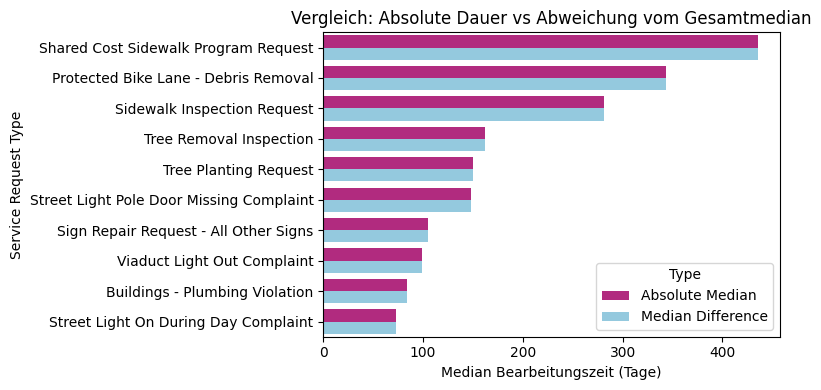

In [38]:
# Top 10 absolut langsamste Medianwerte
top10_absolute = (
    median_by_type
    .sort_values("median_days", ascending=False)
    .head(10)
    .assign(Type="Absolute Median")
)

# Top 10 mit grösster Median Differenz
top10_diff = (
    median_by_type
    .sort_values("median_diff", ascending=False)
    .head(10)
    .assign(Type="Median Difference")
)

comparison_df = (
    pd.concat([top10_absolute, top10_diff], axis=0)
)

plt.figure(figsize=(8,4))

sns.barplot(
    data=comparison_df,
    x="median_days",
    y="SR_TYPE",
    hue="Type",
    orient="h",
    palette=["mediumvioletred", "skyblue"]
)

plt.xlabel("Median Bearbeitungszeit (Tage)")
plt.ylabel("Service Request Type")
plt.title("Vergleich: Absolute Dauer vs Abweichung vom Gesamtmedian")
plt.tight_layout()
plt.show()

Interpretation
Die dargestellten SR_TYPES gehören zu den langsamsten Prozessen im gesamten System. Ihre Medianzeiten liegen weit über dem Gesamtmedian ( ca. 0 Tage), weshalb absolute Median und Median-Differenz nahezu identisch sind. Diese Typen weisen damit strukturell besonders lange Bearbeitungszeiten auf.

### Bearbeitungszeiten nach District

In [39]:
department = "OWNER_DEPARTMENT"

median_by_owner = (
    erledigt.groupby(department)["response_time"]
    .median()
    .sort_values()
    .reset_index(name="median_days")
)

median_by_owner
print("Schnellste Departments:")
print(median_by_owner.head(10))

print("\nLangsamste Departments:")
print(median_by_owner.tail(10))

Schnellste Departments:
                       OWNER_DEPARTMENT  median_days
0                     311 City Services     0.000000
1                              Aviation     0.000000
2                               Finance     0.000000
3                      Outside Agencies     0.085405
4               Animal Care and Control     0.898924
5  DWM - Department of Water Management     1.639358
6                Streets and Sanitation     2.611071
7   CDOT - Department of Transportation     3.777541
8                                  Fire     7.040179
9                                Health     8.363206

Langsamste Departments:
                                   OWNER_DEPARTMENT  median_days
4                           Animal Care and Control     0.898924
5              DWM - Department of Water Management     1.639358
6                            Streets and Sanitation     2.611071
7               CDOT - Department of Transportation     3.777541
8                                          

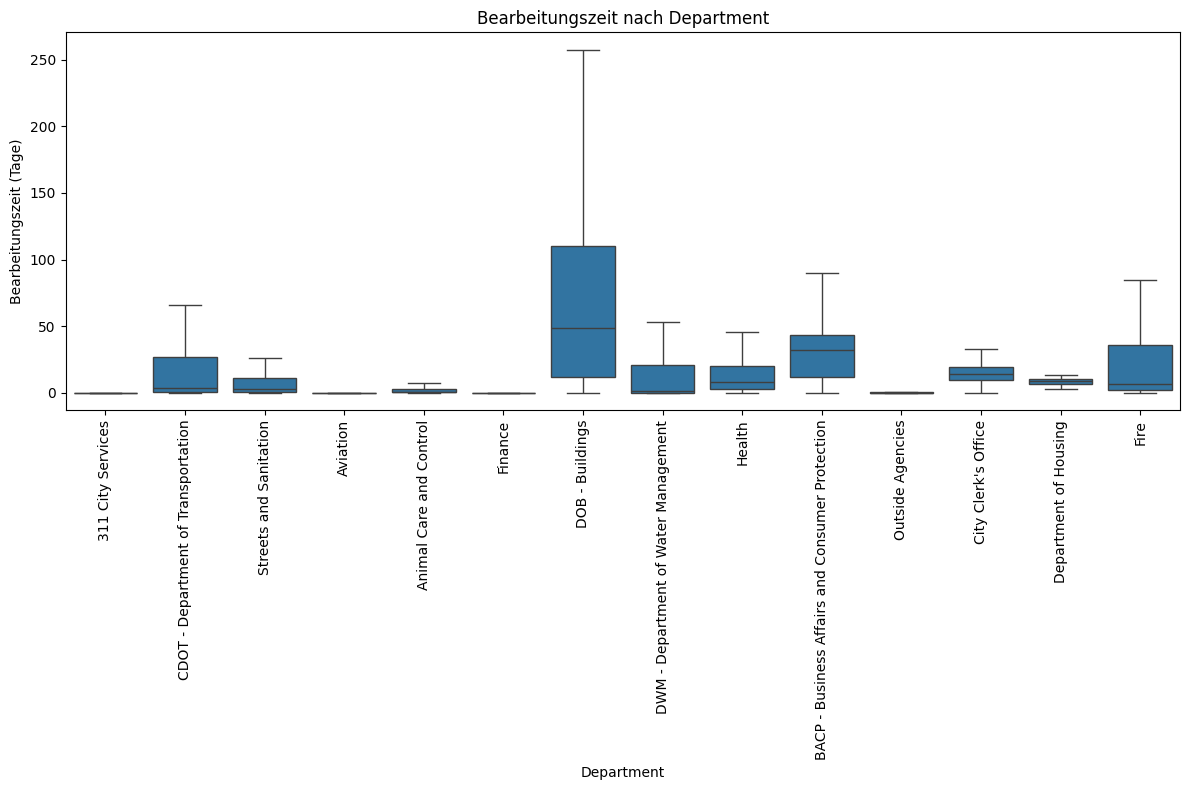

In [40]:
plt.figure(figsize=(12,8))
sns.boxplot(
    data=erledigt,
    x="OWNER_DEPARTMENT",
    y="response_time",
    showfliers=False
)
plt.xticks(rotation=90)
plt.title("Bearbeitungszeit nach Department")
plt.xlabel("Department")
plt.ylabel("Bearbeitungszeit (Tage)")
plt.tight_layout()
plt.show()

In [41]:
# Unterscheiden sich die Departments signifikant?
groups = [
    erledigt[erledigt["OWNER_DEPARTMENT"] == d]["response_time"]
    for d in erledigt["OWNER_DEPARTMENT"].dropna().unique()
]

stat, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {stat:.3f}, p = {p:.3e}")

Kruskal–Wallis H = 1452434.501, p = 0.000e+00


In [42]:
# Welche Departements sich schnell/langsam beim Bearbeiten von Anfragen?
posthoc_dep = sp.posthoc_dunn(
    erledigt,
    val_col="response_time",
    group_col="OWNER_DEPARTMENT",
    p_adjust="fdr_bh"
)
posthoc_dep

,311 City Services,Animal Care and Control,Aviation,BACP - Business Affairs and Consumer Protection,CDOT - Department of Transportation,City Clerk's Office,DOB - Buildings,DWM - Department of Water Management,Department of Housing,Finance,Fire,Health,Outside Agencies,Streets and Sanitation
311 City Services,1.000000e+00,0.000000e+00,5.227224e-05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.453360e-180,1.057724e-11,6.068242e-251,0.000000e+00,0.000000e+00,0.000000e+00
Animal Care and Control,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.353628e-270,1.219699e-233,0.000000e+00,4.153650e-88,1.499867e-08,0.000000e+00,3.318335e-10,7.457855e-76,2.045388e-52,5.417156e-90
Aviation,5.227224e-05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.177998e-179,5.811163e-09,1.024470e-248,0.000000e+00,0.000000e+00,0.000000e+00
BACP - Business Affairs and Consumer Protection,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.485505e-255,1.238104e-04,4.631288e-06,0.000000e+00,2.190624e-02,0.000000e+00,1.260379e-03,6.302896e-19,0.000000e+00,0.000000e+00
CDOT - Department of Transportation,0.000000e+00,2.353628e-270,0.000000e+00,5.485505e-255,1.000000e+00,9.875015e-80,0.000000e+00,2.618360e-59,1.561267e-02,0.000000e+00,1.610453e-02,2.204069e-13,2.993109e-237,3.082550e-298
City Clerk's Office,0.000000e+00,1.219699e-233,0.000000e+00,1.238104e-04,9.875015e-80,1.000000e+00,1.301309e-14,1.270245e-125,1.763336e-01,0.000000e+00,3.602872e-02,1.509108e-07,5.507512e-301,2.343559e-154
DOB - Buildings,0.000000e+00,0.000000e+00,0.000000e+00,4.631288e-06,0.000000e+00,1.301309e-14,1.000000e+00,0.000000e+00,2.628766e-03,0.000000e+00,4.307582e-05,1.066792e-33,0.000000e+00,0.000000e+00
DWM - Department of Water Management,0.000000e+00,4.153650e-88,0.000000e+00,0.000000e+00,2.618360e-59,1.270245e-125,0.000000e+00,1.000000e+00,3.626045e-04,0.000000e+00,1.601640e-04,1.106752e-29,1.695266e-151,5.644966e-07
Department of Housing,1.453360e-180,1.499867e-08,5.177998e-179,2.190624e-02,1.561267e-02,1.763336e-01,2.628766e-03,3.626045e-04,1.000000e+00,7.910848e-167,7.569638e-01,7.130064e-01,1.514358e-18,9.824775e-05
Finance,1.057724e-11,0.000000e+00,5.811163e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.910848e-167,1.000000e+00,5.650265e-230,0.000000e+00,0.000000e+00,0.000000e+00


In [43]:
# Welche Departments sind am ähnlichsten?
similar_pairs = np.where(posthoc_dep >= 0.05)

# in eine Tabelle übersetzen
rows = similar_pairs[0]
cols = similar_pairs[1]

similar_df = pd.DataFrame({
    "Department A": posthoc_dep.index[rows],
    "Department B": posthoc_dep.columns[cols],
    "p": posthoc_dep.values[rows, cols]
})

# Selbst-Vergleiche und Doppelte Paare entfernen
similar_df = similar_df[similar_df["Department A"] < similar_df["Department B"]]

similar_df.sort_values("p", ascending=False)

,Department A,Department B,p
16,Fire,Health,0.987291
11,Department of Housing,Fire,0.756964
12,Department of Housing,Health,0.713006
6,City Clerk's Office,Department of Housing,0.176334


Interpretation
Der Dunn Posthoc teste zeigt das diese Department Paare keinen signifikanten Unterschied zeigen und somit ähnliche Bearbeitungszeiten vorliegen.

In [44]:
# Wie viele p-Werte pro Department unterscheiden sich voneinander?
sig_matrix = (posthoc_dep < 0.05).astype(int)
np.fill_diagonal(sig_matrix.values, 0)
sig_counts = sig_matrix.sum(axis=1).sort_values(ascending=False)
sig_counts

311 City Services                                  13
Animal Care and Control                            13
Aviation                                           13
BACP - Business Affairs and Consumer Protection    13
CDOT - Department of Transportation                13
DOB - Buildings                                    13
Outside Agencies                                   13
DWM - Department of Water Management               13
Finance                                            13
Streets and Sanitation                             13
City Clerk's Office                                12
Health                                             11
Fire                                               11
Department of Housing                              10
dtype: int64

### Regression

In [45]:
import statsmodels.api as sm
# Täglicher Workload und mediane Bearbeitungszeit
daily = erledigt.groupby(erledigt["CREATED_DATE"].dt.date).agg(
    workload=("SR_NUMBER", "count"),          # Anzahl Anfragen pro Tag
    median_rt=("response_time", "median")     # Median Bearbeitungszeit pro Tag
)


X = daily["workload"] #unabhängige Variable
y = daily["median_rt"] #abhängige Variable

X = sm.add_constant(X)               # Intercept-Term hinzufügen

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              median_rt   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     45.08
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           7.29e-11
Time:                        17:51:05   Log-Likelihood:                 255.94
No. Observations:                 366   AIC:                            -507.9
Df Residuals:                     364   BIC:                            -500.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1716      0.028     -6.065      0.0

Interpretation
Da R² 0.11 beträgt, erklärt der Workload einen Teil der Unterschiede in der Bearbeitungszeit, aber es gibt auch andere Faktoren.

Der F-Test mit 7.29e-11 zeigt, der Zusammenhang zwischen Workload und Bearbeitungsziet ist statistisch eindeutig und kein Zufall.

Intercept (const) = –0.1716: Wenn der Workload theoretisch 0 wäre, läge die mediane Bearbeitungsziet bei -0.17 Tagen.

Slope (workload) = 3.699e-05: Wenn der Workload um 1 zusätzlichen Request steigt, erhöht sich die mediane Bearbeitungszeit um 0.00003699 Tage.

Omnibus/ Residuen Interpretation:
Die Residuen sind stark schief und nicht normalverteilt.
Das liegt daran, dass Bearbeitungszeiten extrem rechtsschief sind, da viele 0-Tage Fälle und nur einige lange Fälle existieren.

Insgesamt:
Die Regression zeigt einen kleinen, aber hoch signifikanten positiven Zusammenhang zwischen dem täglichen Anfragevolumen und der Bearbeitungszeit.
Pro zusätzlichem Request steigt die mediane Bearbeitungszeit um etwa 3 Sekunden, was sich bei mehreren Tausend Fällen deutlich auswirkt.
Das Modell erklärt jedoch nur 11% der Variation und verletzt Normalitäts- und Unabhängigkeitsannahmen.

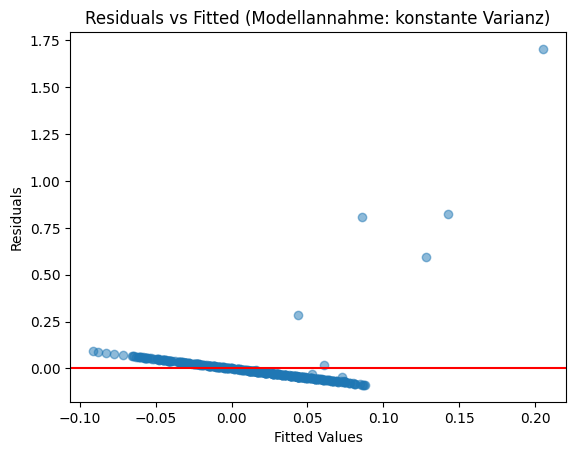

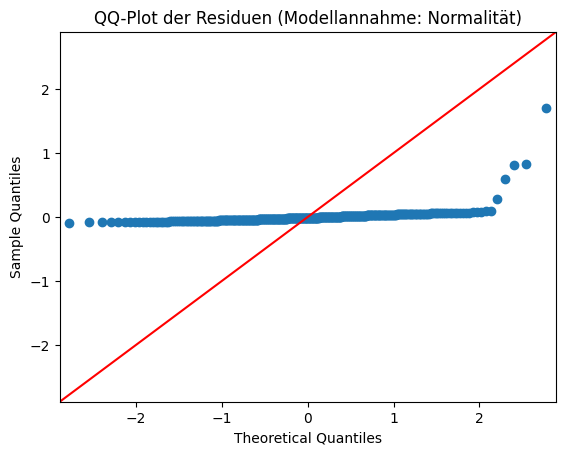

In [46]:
# Residualanalyse
residuals = model.resid
fitted = model.fittedvalues

# Residuen vs Fitted
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color="red")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Modellannahme: konstante Varianz)")
plt.show()

# QQ-Plot
sm.qqplot(residuals, line="45")
plt.title("QQ-Plot der Residuen (Modellannahme: Normalität)")
plt.show()

Interpretation
Im Residuals vs Fitted-Plot sieht man, dass die meisten Punkte nahe bei 0 liegen, aber einzelne Punkte weit darüber hinausschießen. Das bedeutet, dass die Varianz nicht konstant ist. Bei kleinen Werten ist die Streuung minimal, bei größeren Werten wird sie plötzlich viel größer.

Im QQ-Plot sieht man, dass die Punkte deutlich von der roten Linie abweichen, besonders am rechten Rand. Das bedeutet, dass die Residuen nicht normalverteilt sind und eine starke Rechtsschiefe und einige große Ausreißer gibt.

## 4. Einflussfaktoren auf die Performance

### Zusammenhang zwischen Workload und Bearbeitungszeit

### Bearbeitungszeit nach Wochentag

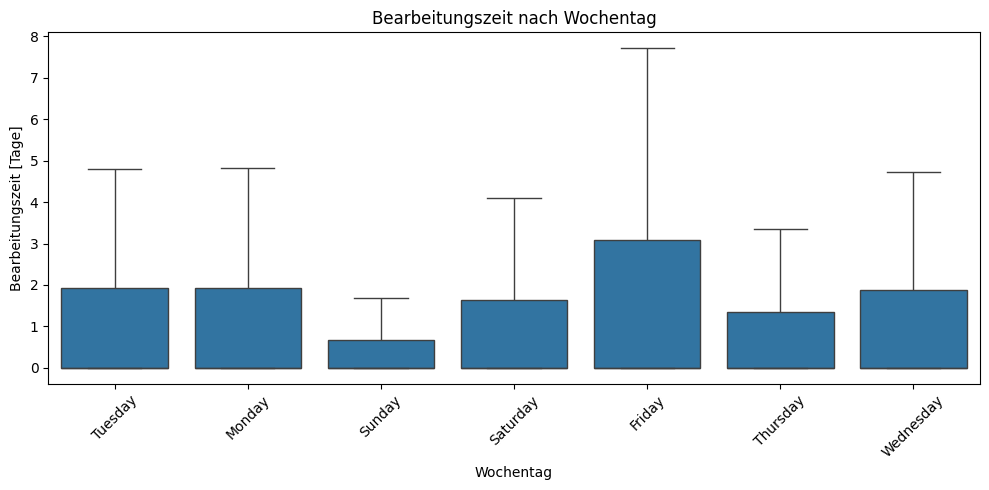

In [47]:
erledigt["weekday"] = erledigt["CREATED_DATE"].dt.day_name()

plt.figure(figsize=(10,5))
sns.boxplot(x="weekday", y="response_time", data=erledigt, showfliers=False)
plt.xticks(rotation=45)
plt.title("Bearbeitungszeit nach Wochentag")
plt.xlabel("Wochentag")
plt.ylabel("Bearbeitungszeit [Tage]")
plt.tight_layout()
plt.show()

### Bearbeitungszeit nach Tageszeit mit einem Scatterplot

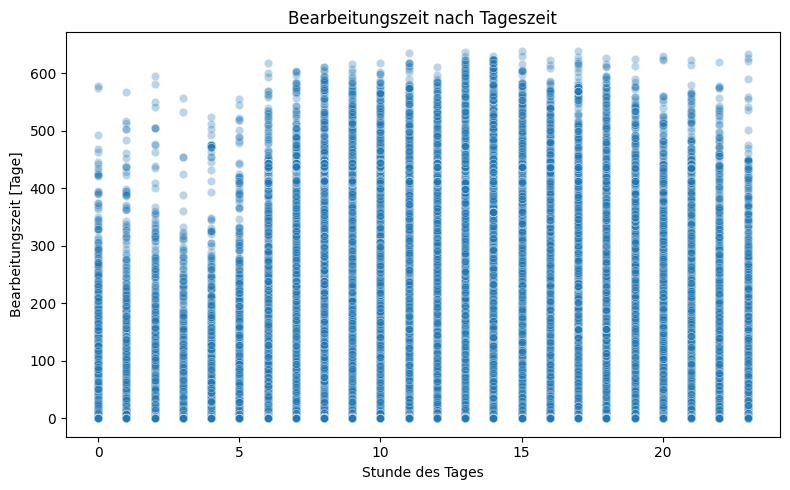

In [48]:
erledigt["hour"] = erledigt["CREATED_DATE"].dt.hour

plt.figure(figsize=(8,5))
sns.scatterplot(x="hour", y="response_time", data=erledigt, alpha=0.3)
plt.title("Bearbeitungszeit nach Tageszeit")
plt.xlabel("Stunde des Tages")
plt.ylabel("Bearbeitungszeit [Tage]")
plt.tight_layout()
plt.show()

### Durchschnittliche Bearbeitungszeit pro Wochentag

In [49]:
avg_by_weekday = (
    erledigt.groupby("weekday")["response_time"]
    .median()  # Median wegen Schiefe robuster
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)
print("\nMedian der Bearbeitungszeit pro Wochentag:")
print(avg_by_weekday.round(3))


Median der Bearbeitungszeit pro Wochentag:
weekday
Monday       0.0
Tuesday      0.0
Wednesday    0.0
Thursday     0.0
Friday       0.0
Saturday     0.0
Sunday       0.0
Name: response_time, dtype: float64


Intepretation
Der Median = 0.0 sagt aus, dass 50 % aller Requests eine Bearbeitungszeit ≤ 0 Tage haben. Die meisten Anfragen wurden dementsprechend innerhalb weniger Stunden nach Erstellung abgeschlossen, also am selben Tag.

Dies wiederspiegelt auch den QQ-Plot von vorhin. Dieser zeigte eine stark rechtsschiefe Verteilung, also viele kleine Werte, aber eben wenige extreme grosse Werte.

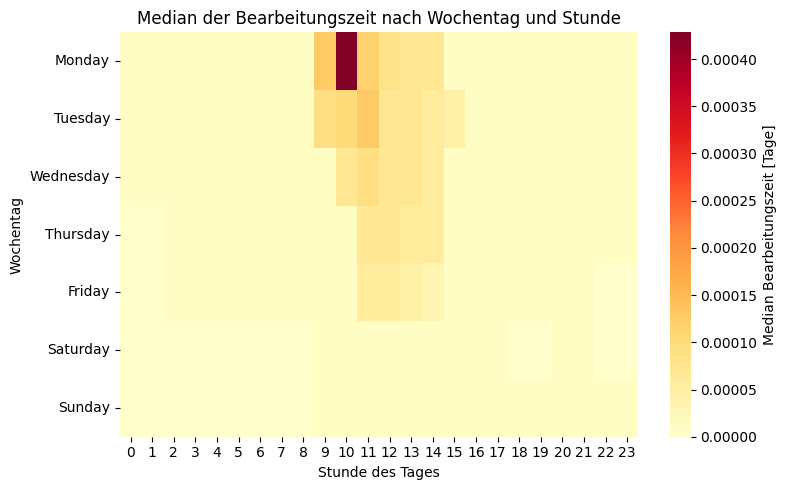

In [50]:
# Durchschnittliche Bearbeitungszeit nach Wochentag und Stunde
pivot = erledigt.pivot_table(index="weekday", columns="hour", values="response_time", aggfunc="median")
pivot = pivot.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.figure(figsize=(8,5))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={"label": "Median Bearbeitungszeit [Tage]"})
plt.title("Median der Bearbeitungszeit nach Wochentag und Stunde")
plt.xlabel("Stunde des Tages")
plt.ylabel("Wochentag")
plt.tight_layout()
plt.show()

In [51]:
# Wenn viele Anfragen eingehen, verlangsamt das die Bearbeitungszeit?
daily = erledigt.groupby(erledigt["CREATED_DATE"].dt.date).agg(
    workload=("SR_NUMBER","count"),
    median_rt=("response_time","median")
)
stats.spearmanr(daily["workload"], daily["median_rt"])

SignificanceResult(statistic=np.float64(0.4611826733874099), pvalue=np.float64(1.1259394872240435e-20))

Interpretation
Da Spearman bei 0.46 liegt, steigt an Tagen mit vielen Requests auch die Bearbeitungszeit.

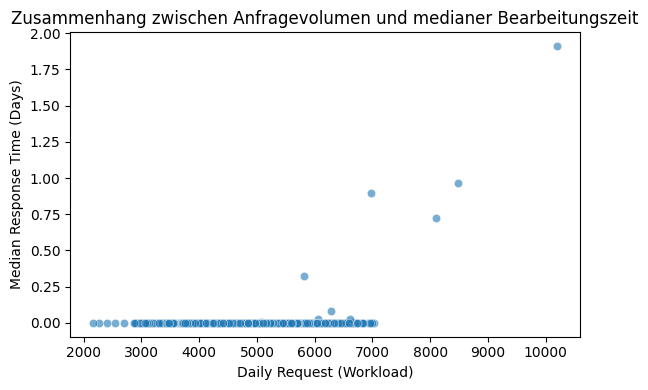

In [52]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=daily, x="workload", y="median_rt", alpha=0.6)
plt.xlabel("Daily Request (Workload)")
plt.ylabel("Median Response Time (Days)")
plt.title("Zusammenhang zwischen Anfragevolumen und medianer Bearbeitungszeit")
plt.tight_layout()
plt.show()

Interpretation:
Großteils liegt die Bearbeitungsziet bie 0 Tagen bei einem Workload von bis zu etwa 6000 Anfragen.
Erste bei hohen Anfragevolumen ab etwa 7000 Requests steigt die mediane Bearbeitungszeit deutlich. Das System verlangsamt sich also bei hohen Requests offenbar und kann bis zu knapp 2 Tage dauern.

### Jahreszeiten und Feiertagseffekte auf die Bearbeitungszeit

In [53]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

df["season"] = df["CREATED_DATE"].dt.month.apply(get_season)

In [54]:
import holidays

us_holidays = holidays.US(years=[2024])  # US Federal Holidays
# Neue Spalte "is_holiday" hinzufügen
df["is_holiday"] = df["CREATED_DATE"].dt.normalize().isin(us_holidays)

C:\Users\erica\AppData\Local\Temp\ipykernel_3928\3755260676.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df["CREATED_DATE"].dt.normalize().isin(us_holidays)


In [55]:
df["season"] = df["CREATED_DATE"].dt.month.apply(get_season)

erledigt = df[df["STATUS"] == "completed"].copy()

groups = [
    erledigt[erledigt["season"] == s]["response_time"]
    for s in ["Winter", "Spring", "Summer", "Fall"]
]

stat, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {stat:.3f}, p = {p:.3f}")


Kruskal–Wallis H = 10475.717, p = 0.000


In [56]:
# Unterschiede in der Bearbeitungszeit an Feiertagen vs. Nicht-Feiertagen
holiday_times = erledigt[erledigt["is_holiday"] == True]["response_time"]
nonholiday_times = erledigt[erledigt["is_holiday"] == False]["response_time"]

u, p = stats.mannwhitneyu(holiday_times, nonholiday_times, alternative='two-sided')
print(f"Mann-Whitney U = {u:.3f}, p = {p:.3e}")

print(len(holiday_times), len(nonholiday_times))

Mann-Whitney U = 34487064033.000, p = 0.000e+00
44064 1788055


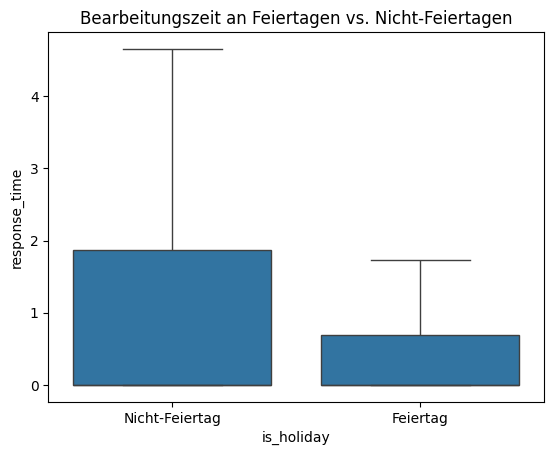

In [57]:
sns.boxplot(data=erledigt, x="is_holiday", y="response_time", showfliers=False)
plt.xticks([0,1], ["Nicht-Feiertag", "Feiertag"])
plt.title("Bearbeitungszeit an Feiertagen vs. Nicht-Feiertagen")
plt.show()

In [58]:
# Werden Anfragen an Feiertagen genauso schnell erledigt wie sonst?
p_fast = erledigt.groupby("is_holiday")["response_time"].apply(lambda x: (x < 1).mean())
print(p_fast)

is_holiday
False    0.713166
True     0.787468
Name: response_time, dtype: float64


Interpretation
An Feiertagen werden Service Requests im Durchschnitt nicht langsamer, sondern sogar etwas schneller bearbeitet. Während an normalen Tagen etwa 71 % der Anfragen innerhalb eines Tages abgeschlossen werden, liegt dieser Anteil an Feiertagen bei rund 79 %. Dies deutet darauf hin, dass Feiertage keinen negativen Einfluss auf die Service-Performance haben.

In [59]:
# Gibt es dann an Feiertagen weniger Anfragen?
daily_workload = df.groupby(df["CREATED_DATE"].dt.date).size()
df["day"] = df["CREATED_DATE"].dt.date

workload_holiday = df[df["is_holiday"]].groupby("day").size()
workload_normal  = df[~df["is_holiday"]].groupby("day").size()

stats.mannwhitneyu(workload_holiday, workload_normal)

MannwhitneyuResult(statistic=np.float64(994.5), pvalue=np.float64(0.005593950002069361))

Interpretation
Da p = 0.056 liegt unterscheidet sich der Workload an Feiertagen signifikant von dem an normalen Tagen.

In [60]:
# Kommen an Feiertagen "einfachere" Anfragen?
holiday_types = df[df["is_holiday"]]["SR_TYPE"].value_counts(normalize=True)
normal_types  = df[~df["is_holiday"]]["SR_TYPE"].value_counts(normalize=True)

comparison_holidays = pd.concat([holiday_types, normal_types], axis=1, keys=["holiday", "normal"])
print(comparison_holidays)

                                                     holiday        normal
SR_TYPE                                                                   
311 INFORMATION ONLY CALL                           0.426817  3.565349e-01
Aircraft Noise Complaint                            0.232877  1.783320e-01
Graffiti Removal Request                            0.032126  5.239935e-02
Abandoned Vehicle Complaint                         0.021095  2.624035e-02
Pothole in Street Complaint                         0.020172  2.693452e-02
Garbage Cart Maintenance                            0.017337  2.586785e-02
Street Light Out Complaint                          0.017117  2.054784e-02
Rodent Baiting/Rat Complaint                        0.016546  2.407328e-02
Traffic Signal Out Complaint                        0.011448  1.382612e-02
Tree Debris Clean-Up Request                        0.010130  1.792424e-02
Building Violation                                  0.009317  1.079843e-02
Dead Animal Pick-Up Reque

In [61]:
# Häufigere Typen an Feiertagen
comparison_holidays["holiday_minus_normal"] = comparison_holidays["holiday"] - comparison_holidays["normal"]
comparison_holidays.sort_values("holiday_minus_normal", ascending=False).head(20)

,holiday,normal,holiday_minus_normal
SR_TYPE,,,
311 INFORMATION ONLY CALL,0.426817,0.356535,0.070282
Aircraft Noise Complaint,0.232877,0.178332,0.054545
No Water Complaint,0.005208,0.001962,0.003246
Open Fire Hydrant Complaint,0.006526,0.003621,0.002905
Buildings - Plumbing Violation,0.005735,0.004284,0.001451
Yard Waste Pick-Up Request,0.009097,0.007824,0.001273
Stray Animal Complaint,0.007515,0.006749,0.000766
Report an Injured Animal,0.005801,0.005116,0.000685
Vicious Animal Complaint,0.004219,0.003675,0.000544


In [62]:
# Seltene Typen an Feiertagen
comparison_holidays["normal_minus_holiday"] = comparison_holidays["normal"] - comparison_holidays["holiday"]
comparison_holidays.sort_values("normal_minus_holiday", ascending=False).head(20)

,holiday,normal,holiday_minus_normal,normal_minus_holiday
SR_TYPE,,,,
Graffiti Removal Request,0.032126,0.052399,-0.020274,0.020274
Tree Trim Request (NO LONGER BEING ACCEPTED),0.005164,0.022799,-0.017636,0.017636
Garbage Cart Maintenance,0.017337,0.025868,-0.008531,0.008531
Tree Debris Clean-Up Request,0.010130,0.017924,-0.007794,0.007794
Rodent Baiting/Rat Complaint,0.016546,0.024073,-0.007527,0.007527
Tree Emergency,0.008064,0.014943,-0.006879,0.006879
Pothole in Street Complaint,0.020172,0.026935,-0.006763,0.006763
Abandoned Vehicle Complaint,0.021095,0.026240,-0.005146,0.005146
Tree Removal Inspection,0.005845,0.010931,-0.005086,0.005086


Interpretation Feiertage und Bearbeitungszeit:
Die Analyse der Service-Request-Typen zeigt deutlich, dass an Feiertagen nicht dieselben Meldearten auftreten wie an normalen Tagen. Feiertage weisen einen überdurchschnittlich hohen Anteil an einfachen und schnell bearbeitbaren Kategorien wie „311 Information Only Call“ oder „Aircraft Noise Complaint“ auf, während komplexe und behördlich regulierte Prozesse (z. B. Bauinspektionen, Tree Trim Requests, Sign Repairs) nahezu vollständig fehlen. Diese veränderte Zusammensetzung erklärt maßgeblich, warum Anfragen an Feiertagen schneller abgeschlossen werden als an regulären Tagen.

## 5. Gesamtanalyse der Performance übers Jahr der Bearbeitungszeit

In [63]:
erledigt["month"] = erledigt["CREATED_DATE"].dt.to_period("M")

monthly_stats = erledigt.groupby("month")["response_time"].agg(
    median="median",
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
)

monthly_stats

,median,iqr
month,,
2024-01,0.000012,1.006979
2024-02,0.000012,0.953866
2024-03,0.000012,0.979716
2024-04,0.000012,1.143600
2024-05,0.000012,2.718160
2024-06,0.000012,2.735301
2024-07,0.000012,4.705920
2024-08,0.000012,3.045660
2024-09,0.000012,3.159048


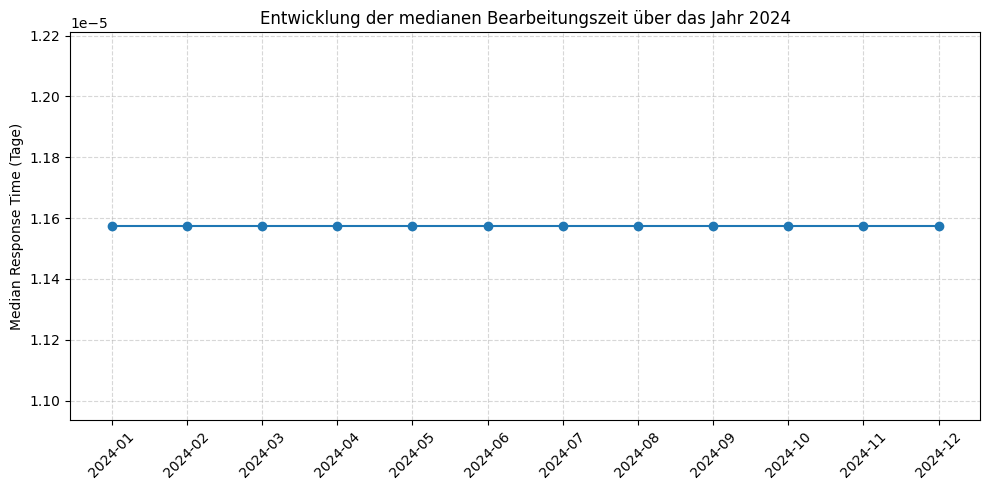

In [64]:
plt.figure(figsize=(10,5))
plt.plot(monthly_stats.index.astype(str), monthly_stats["median"], marker="o")
plt.xticks(rotation=45)
plt.ylabel("Median Response Time (Tage)")
plt.title("Entwicklung der medianen Bearbeitungszeit über das Jahr 2024")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [65]:
groups = [
    group["response_time"].dropna()
    for _, group in erledigt.groupby("month")
]

stat, p = stats.kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.3f}")

Kruskal-Wallis H = 15646.966, p = 0.000


In [66]:
month_numbers = monthly_stats.index.astype(str).str[-2:].astype(int)

rho, p_spear = stats.spearmanr(month_numbers, monthly_stats["median"])
print("Spearman:", rho, "p:", p_spear)

Spearman: nan p: nan


C:\Users\erica\AppData\Local\Temp\ipykernel_3928\2004637425.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p_spear = stats.spearmanr(month_numbers, monthly_stats["median"])


In [67]:
# Die 5 häufigsten SR_TYPEs jeden Monat
top5 = erledigt["SR_TYPE"].value_counts().head(5).index

trend_data = (
    erledigt[erledigt["SR_TYPE"].isin(top5)]
    .assign(month=lambda x: x["CREATED_DATE"].dt.to_period("M"))
    .groupby(["SR_TYPE", "month"])["response_time"]
    .median()
    .reset_index()
)

trend_data

,SR_TYPE,month,response_time
0,311 INFORMATION ONLY CALL,2024-01,0.000000
1,311 INFORMATION ONLY CALL,2024-02,0.000000
2,311 INFORMATION ONLY CALL,2024-03,0.000000
3,311 INFORMATION ONLY CALL,2024-04,0.000000
4,311 INFORMATION ONLY CALL,2024-05,0.000000
5,311 INFORMATION ONLY CALL,2024-06,0.000000
6,311 INFORMATION ONLY CALL,2024-07,0.000000
7,311 INFORMATION ONLY CALL,2024-08,0.000000
8,311 INFORMATION ONLY CALL,2024-09,0.000000
9,311 INFORMATION ONLY CALL,2024-10,0.000000


In [68]:
# Verändert sich die Bearbeitungszeit eines Service Request Typs über die Monate des Jahres 2024 hinweg signifikant mit Kurskal-Wallis Test?
results_kw = []

for sr_type, group in erledigt.groupby("SR_TYPE"):
    # nach Monat gruppieren
    monthly = [
        g["response_time"].dropna()
        for _, g in group.groupby(group["CREATED_DATE"].dt.to_period("M"))
    ]
    # zu wenig Daten, dann überspringen
    if len(monthly) < 3:
        continue
    
    stat, p = stats.kruskal(*monthly)
    results_kw.append([sr_type, p])

results_kw = pd.DataFrame(results_kw, columns=["SR_TYPE", "p_kw"])
results_kw["significant"] = results_kw["p_kw"] < 0.05

results_kw.sort_values("p_kw")


,SR_TYPE,p_kw,significant
0,311 INFORMATION ONLY CALL,0.000000e+00,True
2,Aircraft Noise Complaint,0.000000e+00,True
4,Alley Pothole Complaint,0.000000e+00,True
9,Blue Recycling Cart,0.000000e+00,True
11,Buildings - Plumbing Violation,0.000000e+00,True
31,Graffiti Removal Request,0.000000e+00,True
30,Garbage Cart Maintenance,0.000000e+00,True
44,Nuisance Animal Complaint,0.000000e+00,True
51,Pothole in Street Complaint,0.000000e+00,True
61,Rodent Baiting/Rat Complaint,0.000000e+00,True


Die Analyse der Bearbeitungszeiten über das Jahr 2024 zeigt, dass der überwiegende Teil der Service-Typen signifikante monatliche Unterschiede aufweist (Kruskal-Wallis-Test, p < 0.05). Dies deutet darauf hin, dass die Bearbeitungsdauer vieler Meldungsarten stark von saisonalen Faktoren, Arbeitslast-Schwankungen oder prozessbedingten Einflüssen abhängt. Nur wenige SR_TYPES zeigen keine signifikanten Veränderungen über das Jahr hinweg, was auf sehr stabile und konsistente Bearbeitungsprozesse hindeutet.

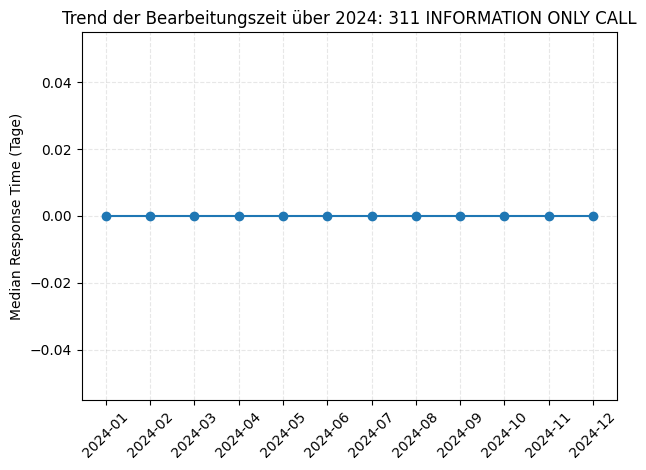

In [69]:
sr = "311 INFORMATION ONLY CALL"

subset = trend_data[trend_data["SR_TYPE"] == sr]

plt.plot(subset["month"].astype(str), subset["response_time"], marker="o")
plt.xticks(rotation=45)
plt.ylabel("Median Response Time (Tage)")
plt.title(f"Trend der Bearbeitungszeit über 2024: {sr}")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

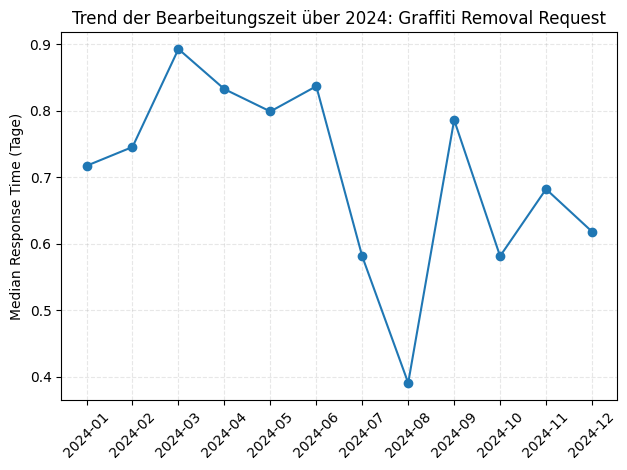

In [70]:
sr = "Graffiti Removal Request"

subset = trend_data[trend_data["SR_TYPE"] == sr]

plt.plot(subset["month"].astype(str), subset["response_time"], marker="o")
plt.xticks(rotation=45)
plt.ylabel("Median Response Time (Tage)")
plt.title(f"Trend der Bearbeitungszeit über 2024: {sr}")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Gesamtinterpretation:
Die Trendanalyse über das Jahr 2024 zeigt keine Veränderung in der medianen Bearbeitungszeit, da der Median in allen Monaten konstant bei 0 Tagen lag. 
Jedoch gibt es deutliche unterschiede zwischen den SR_Types.